<a href="https://www.kaggle.com/code/mingtr/lendingclub-eda-xgboost-shap-interpretation?scriptVersionId=92811394" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# for visualize xgb_model tree 
# may install directly from https://graphviz.org/download/ if there is any error
! pip install graphviz

In [2]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns

# for models
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import plot_roc_curve, roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from xgboost import plot_importance
import shap

from sklearn.linear_model import LogisticRegression

# display all the columns and rows 
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', None)
# set figure size for single graphs 
plt.rcParams['figure.figsize'] = [15, 6]

In [3]:
# Import data
# Columns no.(1,48,58,117,127,128,129,132,133,134,137) have mixed types, so low_memory=False is included
raw_data = pd.read_csv('../input/lending-club-20072020q1/Loan_status_2007-2020Q3.gzip', nrows=7*10**5, low_memory=False)

1  PROBLEM STATEMENT

2  EXPLORATORY DATA ANALYSIS (EDA)

2.1  About the dataset

2.1.1  General information

2.1.2  Feature description

2.2  Univariate EDA

2.2.1  Numerical data

2.2.2  Categorical data

2.3  Bivariate EDA

2.3.1  Loan status

2.3.1.1  loan_status and term

2.3.1.2  loan_status and grade

2.3.1.3  loan_status and home_ownership

2.3.1.4  loan_status and verification_status

2.3.1.5  loan_status and annual_inc_range, emp_length, and purpose

2.3.1.6  loan_status and open_acc/ total_acc

2.3.1.7  Loan status and interest rate / loan amount

2.3.1.8  Loan status per state

2.3.2  Loan amount

2.3.2.1  Loan amount vs year experience

2.3.2.2  Loan amount and term

2.3.2.3  Loan amount and purpose

2.3.3  Purpose

2.3.3.1  Purpose and term

2.3.3.2  Purpose and grade

2.3.4  Interest rate

2.3.4.1  Interest rate and annual income

2.3.4.2  Interest rate and term

2.3.4.3  Interest vs sub-grade

2.3.5  Pearson correlation matrix

2.4  Conclusion of EDA

2.5  Data prepration

2.5.1  Cleaning columns

2.5.1.1  Reason 1: Unrelated information

2.5.1.2  Reason 2: Missing values

2.5.1.3  Reason 3: Uninformative for classification

2.5.1.4  Reason 4: Collected data after a loan is granted

2.5.1.5  Reason 5: High correlation - Based on Pearson correlation matrix

2.5.2  Cleaning rows

2.5.3  Convert data types

2.5.4  Set up independant and dependant variables

2.5.5  Data split

3  XGBOOST MODEL DEVELOPMENT

3.1  Initial model

3.2  Tuning hyperparameters

3.2.0.1  Approach 1

3.2.0.2  Approach 2

3.3  Optimized model

3.4  Final model

3.5  Cross validation

4  INTERPRET XGBOOST MODEL RESULS

4.1  Global explanation

4.1.1  Feature Permutation Importance

4.1.2  Feature importance

4.1.3  SHAP - Global interpretation

4.1.4  Local Interpretability - Individual SHAP Values

4.1.5  XGBoost tree

5  COMPARING TO LOGISTIC REGRESSION MODEL

6  CONCLUSION

This project use the most popular approach of the Cross-Industry Standard Process for Data Mining (CRISP-DM), (Wirth et al.,2000, p.6). The framework as below:

1. Problem statement/Business understanding

2. Data Understanding (Exploratory Data Analysis)

3. Data Preparation

4. Modeling development

5. Evaluation/Interpretation

6. Communication/Deployment

Source: Wirth, R. & Hipp, Jochen. (2000). CRISP-DM: Towards a standard process model for data mining. Proceedings of the 4th International Conference on the Practical Applications of Knowledge Discovery and Data Mining. 

# PROBLEM STATEMENT

LendingClub company provides P2P lending, which becomes more and more popular. Investors are responsible for their own decision on lending. Even though the company has fitter borrowers who meet the minimum requirements, there is still a huge risk of non-repayment. This is the problem that this project works on by making the prediction of loan status for these people.

The final product of this project is a localhost web app that presents an explanation dashboard of a predictive model to classify which customers fall into categories of 'Fully Paid' or Charged Off'. End-users can understand the model as well as receive predictive results for a new customer.

In brief, this project is created with the purpose of:
- improving profitability for the lenders
- providing a lightweight tool to support the process of decision making
- an app with an easily used interface

# EXPLORATORY DATA ANALYSIS (EDA)

## About the dataset

### General information

* Data is collected originally from LendingClub data website. The LendingClub Notes platform retired on December 31, 2020 (https://www.lendingclub.com/investing/peer-to-peer), so the accuracy of this data sample solely depends on the collection of individuals on Kaggle. 

* Content: The personal information of customers is collected during the membership, application process and from credit bureaus such as date of birth, income, account information, credit history and credit score, credit card and other debt information.

* Overall information of the dataset:
    - Source: https://www.kaggle.com/ethon0426/lending-club-20072020q1?select=Loan_status_2007-2020Q3.gzip, the zipped file contains a *.gzip file of data and an excel file of feature description.
    - Duration: 2007-2020
    - Context: data is collected from customers in US
    (https://help.lendingclub.com/hc/en-us/articles/213706208-Qualifying-for-a-personal-loan) ?
    - Currency: USD
    - Types of features:
        - Loan Characteristics such as loan amount, term and purpose
        - Demographic data such as employment status, employment length and house ownership
        - Behavioral data related to historical payments

Because the problem to solve here is prediction for loan outcomes before it is granted, so the features provided before a loan is granted will be focus on, and the rest will be ignored.

In [4]:
# create a copy of data to work on, avoiding modifying the original dataset
df = raw_data.copy()
# first look of the data
df.head().transpose()

0  \
Unnamed: 0                                                                                                 0   
id                                                                                                   1077501   
loan_amnt                                                                                             5000.0   
funded_amnt                                                                                           5000.0   
funded_amnt_inv                                                                                       4975.0   
term                                                                                               36 months   
int_rate                                                                                              10.65%   
installment                                                                                           162.87   
grade                                                                                                      B   
sub_grade                                                                                                 B2   
emp_title                                                                                                NaN   
emp_length                                                                                         10+ years   
home_ownership                                                                                          RENT   
annual_inc                                                                                           24000.0   
verification_status                                                                                 Verified   
issue_d                                                                                             Dec-2011   
loan_status                                                                                       Fully Paid   
pymnt_plan                                                                                                 n   
url                                         https://lendingclub.com/browse/loanDetail.action?loan_id=1077501   
purpose                                                                                          credit_card   
title                                                                                               Computer   
zip_code                                                                                               860xx   
addr_state                                                                                                AZ   
dti                                                                                                    27.65   
delinq_2yrs                                                                                              0.0   
earliest_cr_line                                                                                    Jan-1985   
fico_range_low                                                                                         735.0   
fico_range_high                                                                                        739.0   
inq_last_6mths                                                                                           1.0   
mths_since_last_delinq                                                                                   NaN   
mths_since_last_record                                                                                   NaN   
open_acc                                                                                                 3.0   
pub_rec                                                                                                  0.0   
revol_bal                                                                                            13648.0   
revol_util                                                                                             83.7%   
total_acc                                                                  

In [5]:
# drop 'Unnamed: 0', which is a redundant index columns available in the origin data
df.drop(columns=['Unnamed: 0'], inplace=True)

# check the initial dimension of the data
df.shape

(700000, 141)

The dataset contains 700000 rows and 141 columns.

### Feature description
Description of all the feature labels appear in the dataset

In [6]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 3.1 MB/s            


In [7]:
# imported the excel file
des_label = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx').dropna(axis=1, how='all', inplace=False)
des_label

LoanStatNew  \
0                                acc_now_delinq   
1                          acc_open_past_24mths   
2                                    addr_state   
3                                      all_util   
4                                    annual_inc   
5                              annual_inc_joint   
6                              application_type   
7                                   avg_cur_bal   
8                                bc_open_to_buy   
9                                       bc_util   
10                     chargeoff_within_12_mths   
11                      collection_recovery_fee   
12                   collections_12_mths_ex_med   
13                                  delinq_2yrs   
14                                  delinq_amnt   
15                                         desc   
16                                          dti   
17                                    dti_joint   
18                             earliest_cr_line   
19                                   emp_length   
20                                    emp_title   
21                              fico_range_high   
22                               fico_range_low   
23                                  funded_amnt   
24                              funded_amnt_inv   
25                                        grade   
26                               home_ownership   
27                                           id   
28                                      il_util   
29                          initial_list_status   
30                                       inq_fi   
31                                 inq_last_12m   
32                               inq_last_6mths   
33                                  installment   
34                                     int_rate   
35                                      issue_d   
36                           last_credit_pull_d   
37                         last_fico_range_high   
38                          last_fico_range_low   
39                              last_pymnt_amnt   
40                                 last_pymnt_d   
41                                    loan_amnt   
42                                  loan_status   
43                                   max_bal_bc   
44                                    member_id   
45                           mo_sin_old_il_acct   
46                         mo_sin_old_rev_tl_op   
47                        mo_sin_rcnt_rev_tl_op   
48                               mo_sin_rcnt_tl   
49                                     mort_acc   
50                       mths_since_last_delinq   
51                  mths_since_last_major_derog   
52                       mths_since_last_record   
53                           mths_since_rcnt_il   
54                         mths_since_recent_bc   
55                     mths_since_recent_bc_dlq   
56                        mths_since_recent_inq   
57               mths_since_recent_revol_delinq   
58                                 next_pymnt_d   
59                        num_accts_ever_120_pd   
60                               num_actv_bc_tl   
61                              num_actv_rev_tl   
62                                  num_bc_sats   
63                                    num_bc_tl   
64                                    num_il_tl   
65                                num_op_rev_tl   
66                                num_rev_accts   
67                          num_rev_tl_bal_gt_0   
68                                     num_sats   
69                             num_tl_120dpd_2m   
70                                 num_tl_30dpd   
71                           num_tl_90g_dpd_24m   
72                           num_tl_op_past_12m   
73                                     open_acc   
74                                  open_acc_6m   
75                                  open_il_12m   
76                                  open_il_24m   
77                                  open_act_il   
78     

## Univariate EDA
Features are divided into 2 groups: numerical and categorical data.

In [8]:
# check the types of each attribute
df.dtypes.sort_values()

max_bal_bc                                    float64
mo_sin_old_rev_tl_op                          float64
mo_sin_old_il_acct                            float64
delinq_amnt                                   float64
chargeoff_within_12_mths                      float64
bc_util                                       float64
bc_open_to_buy                                float64
avg_cur_bal                                   float64
acc_open_past_24mths                          float64
inq_last_12m                                  float64
total_cu_tl                                   float64
inq_fi                                        float64
total_rev_hi_lim                              float64
all_util                                      float64
hardship_last_payment_amount                  float64
open_rv_24m                                   float64
open_rv_12m                                   float64
il_util                                       float64
total_bal_il                

While most the features are numerical, some has object type which should be examined further in the next part. Due to the large number of variables, we analysis some features which is related to the problem stated.

### Numerical data

In [9]:
# descriptive analysis
df.describe().transpose()

count           mean  \
loan_amnt                                   699999.0   14903.722934   
funded_amnt                                 699999.0   14886.752445   
funded_amnt_inv                             699999.0   14839.452693   
installment                                 699999.0     442.931693   
annual_inc                                  699995.0   76396.270510   
dti                                         699039.0      18.470065   
delinq_2yrs                                 699970.0       0.253348   
fico_range_low                              699999.0     703.196690   
fico_range_high                             699999.0     707.196969   
inq_last_6mths                              699970.0       0.603824   
mths_since_last_delinq                      313234.0      35.497465   
mths_since_last_record                       88262.0      79.346366   
open_acc                                    699970.0      11.183362   
pub_rec                                     699970.0       0.140873   
revol_bal                                   699999.0   15839.048187   
total_acc                                   699970.0      23.157834   
out_prncp                                   699999.0    2152.276966   
out_prncp_inv                               699999.0    2151.974262   
total_pymnt                                 699999.0   14123.052390   
total_pymnt_inv                             699999.0   14074.059527   
total_rec_prncp                             699999.0   11140.779962   
total_rec_int                               699999.0    2802.751099   
total_rec_late_fee                          699999.0       2.022050   
recoveries                                  699999.0     177.499245   
collection_recovery_fee                     699999.0      27.969328   
last_pymnt_amnt                             699999.0    3822.912384   
last_fico_range_high                        699999.0     688.813220   
last_fico_range_low                         699999.0     675.456572   
collections_12_mths_ex_med                  699854.0       0.014320   
mths_since_last_major_derog                 148287.0      44.437395   
policy_code                                 699999.0       1.000000   
annual_inc_joint                             64081.0  122856.378052   
dti_joint                                    64081.0      19.544087   
acc_now_delinq                              699970.0       0.001879   
tot_coll_amt                                629723.0     191.232809   
tot_cur_bal                                 629723.0  141149.709534   
open_acc_6m                                 469283.0       0.899977   
open_act_il                                 469283.0       2.723745   
open_il_12m                                 469283.0       0.653691   
open_il_24m                                 469283.0       1.520590   
mths_since_rcnt_il                          452468.0      21.412235   
total_bal_il                                469283.0   35006.523096   
il_util                                     395609.0      68.072246   
open_rv_12m                                 469283.0       1.247380   
open_rv_24m                                 469283.0       2.679703   
max_bal_bc                                  469283.0    5674.243478   
all_util                                    469174.0      54.944588   
total_rev_hi_lim                            629723.0   34815.200166   
inq_fi                                      469283.0       1.040061   
total_cu_tl                                 469283.0       1.448341   
inq_last_12m                                469283.0       1.995710   
acc_open_past_24mths                        649969.0       4.323346   
avg_cur_bal                                 629687.0   13774.085215   
bc_open_to_buy                              641721.0   12415.911884   
bc_util                                     641422.0      55.556786   
chargeoff_within_12_mths                    699854.0       0.006603   


* Descriptive statistics for each of the numerical variable show the mean, standard deviation, minimum & maximum values and values which fall within 25/50/75% of the total data. Standard deviation measures how dispersed the data is in relation to the mean. Low std indicates that data is clustered around the mean, high std means that data is spread out.

* Variables with significantly higher standard deviation (than the rest) are:
    tot_hi_cred_lim, 
    tot_cur_bal, 
    annual_inc, 
    annual_inc_joint, 
    total_bal_ex_mort, 
    total_il_high_credit_limit, 
    total_bal_il, 
    total_rev_hi_lim, 
    revol_bal_joint, 
    total_bc_limit, 
    revol_bal, 
    bc_open_to_buy, 
    avg_cur_bal, 
    total_pymnt, 
    total_pymnt_inv, 
    funded_amnt_inv, 
    loan_amnt, 
    funded_amnt, 
    hardship_payoff_balance_amount, 
    tot_coll_amt, 
    out_prncp, 
    out_prncp_inv, 
    total_rec_prncp, 
    max_bal_bc, 
    last_pymnt_amnt, 
    total_rec_int, 
    hardship_last_payment_amount, 
    recoveries.

* Among many features, only last_pymnt_amnt column contains negative values (check the min values)

* Columns related to payment history are the ones which have the most missing values(check the column of count):
    mths_since_last_delinq, 
    mths_since_last_major_derog, 
    mths_since_recent_bc_dlq, 
    mths_since_last_record, 
    annual_inc_joint, 
    dti_joint, 
    sec_app_num_rev_accts, 
    sec_app_open_acc, 
    sec_app_open_act_il, 
    sec_app_mort_acc, 
    sec_app_inq_last_6mths, 
    sec_app_collections_12_mths_ex_med, 
    sec_app_chargeoff_within_12_mths, 
    sec_app_fico_range_low, 
    sec_app_fico_range_high, 
    revol_bal_joint, 
    sec_app_revol_util, 
    hardship_payoff_balance_amount, 
    hardship_last_payment_amount, 
    hardship_amount, 
    orig_projected_additional_accrued_interest, 
    deferral_term, 
    hardship_length, 
    hardship_dpd.

* Some of the noticeble features will be examined as below. 

##### Loan amount

In [10]:
# create bins for loan_amnt_range
loan_bin = df['loan_amnt'].value_counts(bins=7).sort_values()
loan_bin

(28714.286, 34357.143]     34292
(34357.143, 40000.0]       44263
(23071.429, 28714.286]     59188
(17428.571, 23071.429]     96482
(460.499, 6142.857]       136814
(11785.714, 17428.571]    149724
(6142.857, 11785.714]     179236
Name: loan_amnt, dtype: int64

In [11]:
# label with the round up numbers
df['loan_amnt_range'] = pd.cut(df['loan_amnt'], bins=7, 
                                 labels=['460-6143', '6143-11786', '11786-17429',
                                         '17429-23071','23071-28714','28714-34357',
                                         '34357-40000'])

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# distribution of loan amount
df['loan_amnt'].hist(bins=7,ax=axs[0])
axs[0].set_title('Distribution of Loan amount', fontsize=16)
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("USD")

# pie chart with the same loan mount ranges
df['loan_amnt_range'].value_counts().plot.pie(ax=axs[1], autopct='%.2f%%')
axs[1].set_title('Loan amount range (USD)', fontsize=16)

Text(0.5, 1.0, 'Loan amount range (USD)')

The histogram and the pie chart are created with the same number of bins and it can be seen that:

* The peak of the histogram or the most common values of loan amount is between 6143 and 11786 USD, which accounts for just above 25% compared to the frequency of other loan amount ranges.
* Loan amount spreads from 460 to 40000 USD.
* Loan amount data is remarkably right-skewed, showing less people applied to borrow an amount of loan above 17429 USD. Most applied loan amount is from 460 to 17429 USD.
* There is no outliers visually detected, meaning no loan amounts which are extremely low or high are presented. 

##### Annual income

In [13]:
# create annual_inc_range, based on https://taxsummaries.pwc.com/united-states/individual/taxes-on-personal-income
cat = [(df['annual_inc'] == 0),
    (df['annual_inc']>=1) & (df['annual_inc']<=9950),
    (df['annual_inc']>9950) & (df['annual_inc']<=40525),
    (df['annual_inc']>40525) & (df['annual_inc']<=86375),
    (df['annual_inc']>86375) & (df['annual_inc']<=164925)]
        
brackets = ['0','1 to 9950','9951 to 40525','40526 to 86375','86376 to 164925']
df['annual_inc_range'] = np.select(cat, brackets)

In [14]:
# plot with figures transformed into percentage
df['annual_inc_range'].value_counts().plot.pie(autopct='%.2f%%', figsize=(15, 6))
plt.title('Annual income range (USD)', fontsize=16) 

Text(0.5, 1.0, 'Annual income range (USD)')

* The income ranges are split based on how the personal income taxes are applied in the USA. The pie chart indicates that about 52% of people applied for loans have annual income from 40526 to 86375 USD. 
* People who earn below 9950 USD are less likely to send applications for loans. 
* There is nearly 5% of applicants have zero yearly income, which is accepted to join the P2P platform.

##### Interest rate 

In [15]:
# remove '%' and convert 'interest' into numeric type
df['int_rate'] = df['int_rate'].str.replace('%','')
df['int_rate'] = pd.to_numeric(df['int_rate'])
df['int_rate'].head()

0    10.65
1    15.27
2    15.96
3    13.49
4    12.69
Name: int_rate, dtype: float64

In [16]:
# create bins for int_rate_range, based on https://www.lendingclub.com/foliofn/rateDetail.action
int_bin = df['int_rate'].value_counts(bins=5).sort_values(ascending=True)
int_bin

(25.854, 30.99]                  11760
(20.718, 25.854]                 41726
(15.582, 20.718]                142739
(5.2829999999999995, 10.446]    237429
(10.446, 15.582]                266345
Name: int_rate, dtype: int64

In [17]:
# labels with rounded figures 
df['int_rate_range'] = pd.cut(df['int_rate'], 
                                 bins=5, 
                                 labels=['5.2-10.4','10.4-15.5','15.5-20.7','20.7-25.8','25.8-31'])

Text(0.5, 1.0, 'Interest rate range')

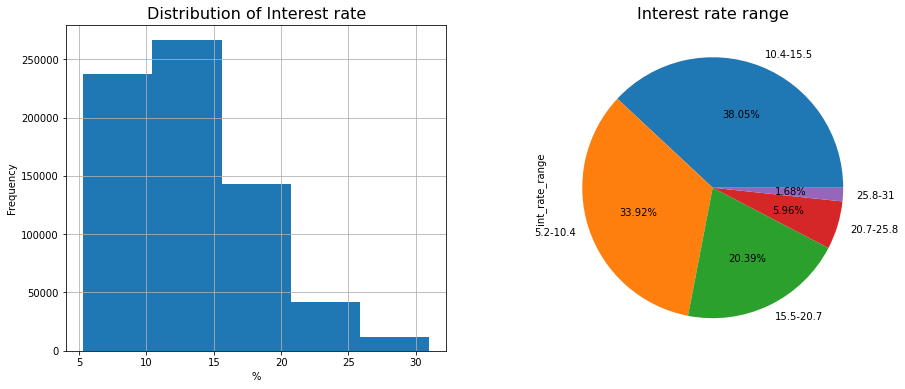

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# histogram
df['int_rate'].hist(bins=5, ax=axs[0])
axs[0].set_title('Distribution of Interest rate', fontsize=16)
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("%")

# pie chart
df['int_rate_range'].value_counts().plot.pie(ax=axs[1], autopct='%.2f%%')
axs[1].set_title('Interest rate range', fontsize=16)

Combining the histogram and the pie chart indicate that:

* The peak of the histogram or the most common values of loan interest rate falls into the range of 10.4%-15.5%, and the second common one is the range of 5.2%-10.4%.
* Loan interest rate spreads from 5.2% to 31%, which also means that the company also provided loans along with high risk accepted, but this is highly uncommon. The interest range from 20.7% to 31% has the lowest frequency. 
* Loan amount data is significantly right-skewed, showing most applied loan interest rates from 5.2% to 15.5%.
* There is no outliers visually detected from the histogram, meaning no extremely low or high interest rate are presented.

##### FICO scores

There are 2 variable with the similar content is fico_range_low and fico_range_high, so a transformation is needed.

In [19]:
# examine the difference between fico_range_high and fico_range_low
df['diff'] = df['fico_range_high'] - df['fico_range_low']
df['diff'].head()

0    4.0
1    4.0
2    4.0
3    4.0
4    4.0
Name: diff, dtype: float64

In [20]:
# check if all the difference is equal to a constant number of 4
df['diff'].value_counts()

4.0    699804
5.0       195
Name: diff, dtype: int64

It can be seen that the difference between fico_range_high and fico_range_low is nearly the same for every applicant, so we will take the average figures for further analysis.

In [21]:
# average of FICO scores
df['FICO_average'] = (df['fico_range_high']+df['fico_range_low'])/2
df['FICO_average'].head()

0    737.0
1    742.0
2    737.0
3    692.0
4    697.0
Name: FICO_average, dtype: float64

In [22]:
# convert FICO scores into categories

## conditions
conditions = [(df['FICO_average']<580),
    (df['FICO_average']>580) & (df['FICO_average']<=669),
    (df['FICO_average']>669) & (df['FICO_average']<=739),
    (df['FICO_average']>739) & (df['FICO_average']<=799),
    (df['FICO_average']>=800)]

## categories
rating = ['Poor', 'Fair', 'Good', 'Very_good', 'Exceptional']

## return an array drawn from 2 lists, and add the new column to df
df['FICO_rating'] = np.select(conditions, rating)

Text(0.5, 1.0, 'FICO scores by range')

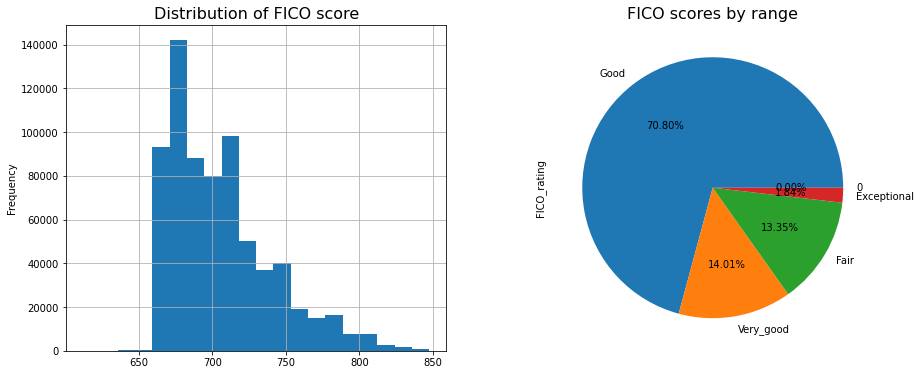

In [23]:
# Distribution 
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# histogram
df['FICO_average'].hist(bins=20, ax=axs[0], figsize=(15, 6))
axs[0].set_title('Distribution of FICO score', fontsize=16)
axs[0].set_ylabel('Frequency')

# pie chart
df['FICO_rating'].value_counts().plot.pie(ax=axs[1], autopct='%.2f%%')
axs[1].set_title('FICO scores by range', fontsize=16)

From pie chart:
* FICO scores is categorized into Bad, Good, Fair, Very_good and Exceptional range.

(Source: P.4, What is a good FICO® Score?. Fair Isaac Corporation. https://www.ficoscore.com/ficoscore/pdf/Frequently-Asked-Questions-About-FICO-Scores.pdf)

* The Bad range does not appear in the pie chart because the company set the minimum requirement is from Good to Excellent category, refusing people who have Bad FICO ranking.

* About 71% of loan applicants have Good FICO scores.

From histogram:
* The FICO score of around 675 is the most frequently appears in the data sample.

* The score distribution is heavily right-skewed. The number of applicants who have Exceptional scores (above 800) is rare, only accounts for 2% of total applicants.

In [24]:
# drop the features which no longer needed
df.drop(columns=['fico_range_low','fico_range_high', 'diff'], inplace=True)

### Categorical data

Features are presented side be side but it is for optimal layout, not checking their mutual relationship.

##### purpose and term

In [25]:
fig, axs = plt.subplots(1,2 , figsize=(15, 6))
# bar chart
df['purpose'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0])
axs[0].set_title('Loan purposes', fontsize=16)
axs[0].set_ylabel("%")

# pie chart
df['term'].value_counts().plot.pie(ax=axs[1], autopct='%.2f%%')
axs[1].set_title('Loan term', fontsize=16)

Text(0.5, 1.0, 'Loan term')

* The first bar graph shows the distribution of the data in regards to the purposes for the loan. The main reason why borrowers are issued a loan is due to "debt consolidation" (accounts for around 55%), meanwhile a secondary main reason is "credit_cards" (only about 25%). Besides, people rarely apply for loans for education, renewable energy or wedding.

* The second pie chart shows loan terms (the number of months that applicants will make payments), and there are only two types of 36 or 60 months. The majority of the loans (about 72%) are set in term of 36 months, which doubles the number of the 60-month loans (28%).

##### grade and sub-grade

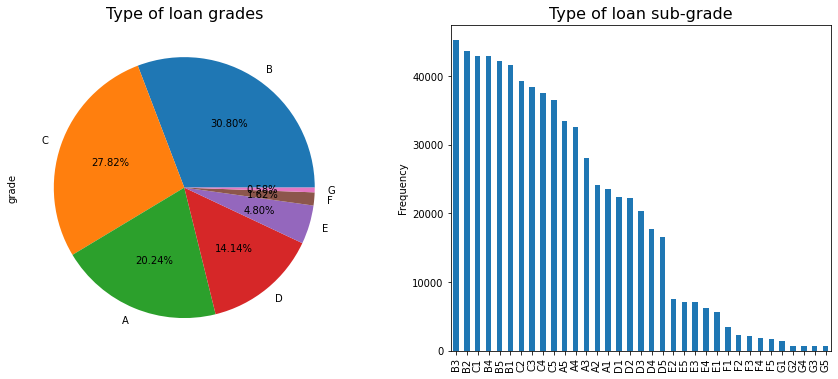

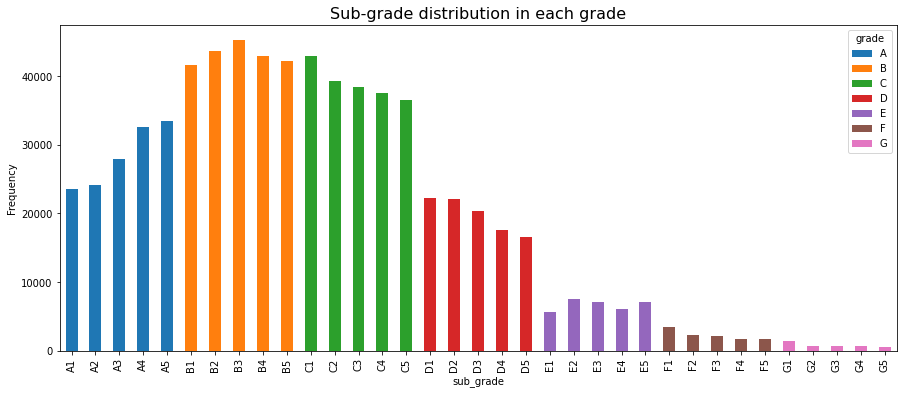

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
# grade
df['grade'].value_counts().plot.pie(ax=axs[0], autopct='%.2f%%')
axs[0].set_title('Type of loan grades', fontsize=16)

# sub-grade
df['sub_grade'].value_counts().plot.bar(ax=axs[1])
axs[1].set_title('Type of loan sub-grade', fontsize=16)
axs[1].set_ylabel('Frequency')
plt.show()

#### Grade vs sub_grade, using crosstab function to count the frequency
pd.crosstab(df['sub_grade'], df['grade']).plot(kind='bar', stacked=True)
plt.title('Sub-grade distribution in each grade', fontsize=16)
plt.ylabel('Frequency')
plt.show()

* As for the loan grade, the majority types are A, B and C, which respectively accounts for about 20%, 31% and 28% of total number of grade types. 
* There are 35 sub-grades in total. Rated loans B3, C1, B4 and B2 the most common one compared to the rest of the sub-grades.
* The third bar chart show that in grade B, D, C and E, the difference in the number of its sub-grades is not significant when compared that in grade A. 

##### emp_length, home ownership, and verification status

Text(0, 0.5, '%')

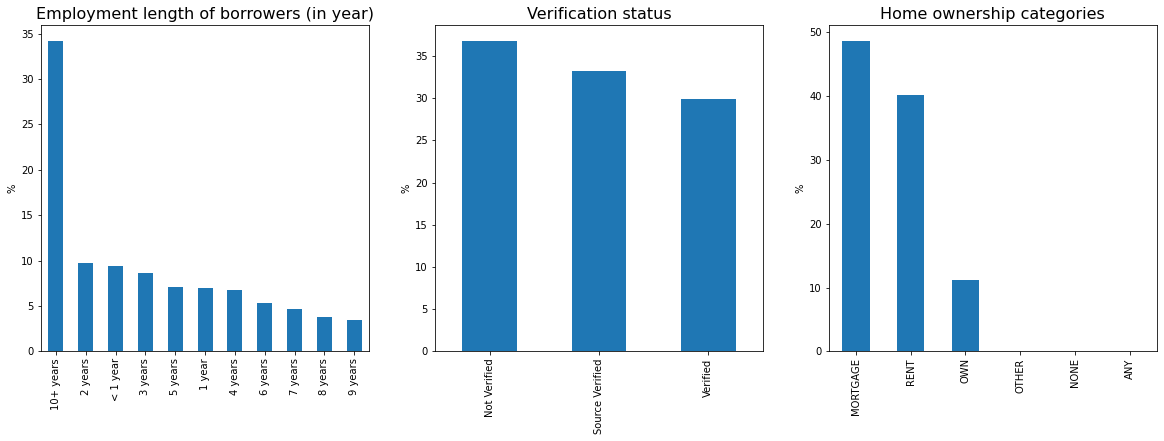

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# employment length plot
df['emp_length'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0])
axs[0].set_title('Employment length of borrowers (in year)', fontsize=16)
axs[0].set_ylabel("%")

# verification status plot
df['verification_status'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[1])
axs[1].set_title('Verification status', fontsize=16)
axs[1].set_ylabel("%")

# Home ownership plot
df['home_ownership'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[2])
axs[2].set_title('Home ownership categories', fontsize=16)
axs[2].set_ylabel("%")

# all the units ae percentage

* Employment length is collected in applications. A significant high percentage (nearly 35%) of the applicants works for a long time of more than 10 years. Moreover, the people who have no jobs or less than 1-year employment accounts for the second highest figures (about 10%) compared to the rest. The number of people with 9 year working accounts for the least (below 5%).

* The next graph representing verification status shows that most of the applicants' income information will be verified (by the company itself or the source is already verified). There is 40% of the applicants' incomes is not verified at the time of exporting data.

* Home ownership bar graph: the most dominating type of ownership is "mortgage" and "rent", which also reflects the reality in US that the majority of citizens do not own theirs properties.

In [28]:
# filter out the applicants who have Not Verified status for their income 
vf = df[(df.verification_status == 'Not Verified')]

# present in transposed style
vf.head().T 

2   \
id                                                                                                   1077175   
loan_amnt                                                                                             2400.0   
funded_amnt                                                                                           2400.0   
funded_amnt_inv                                                                                       2400.0   
term                                                                                               36 months   
int_rate                                                                                               15.96   
installment                                                                                            84.33   
grade                                                                                                      C   
sub_grade                                                                                                 C5   
emp_title                                                                                                NaN   
emp_length                                                                                         10+ years   
home_ownership                                                                                          RENT   
annual_inc                                                                                           12252.0   
verification_status                                                                             Not Verified   
issue_d                                                                                             Dec-2011   
loan_status                                                                                       Fully Paid   
pymnt_plan                                                                                                 n   
url                                         https://lendingclub.com/browse/loanDetail.action?loan_id=1077175   
purpose                                                                                       small_business   
title                                                                                   real estate business   
zip_code                                                                                               606xx   
addr_state                                                                                                IL   
dti                                                                                                     8.72   
delinq_2yrs                                                                                              0.0   
earliest_cr_line                                                                                    Nov-2001   
inq_last_6mths                                                                                           2.0   
mths_since_last_delinq                                                                                   NaN   
mths_since_last_record                                                                                   NaN   
open_acc                                                                                                 2.0   
pub_rec                                                                                                  0.0   
revol_bal                                                                                             2956.0   
revol_util                                                                                             98.5%   
total_acc                                                                                               10.0   
initial_list_status                                                                                        f   
out_prncp                                                                                                0.0   
out_prncp_inv                                                             

Note: A sufficient income is the minimum requirement of applying to any loans, but in LendingClub unverified status does not mean that borrowers are rejected right away, and these applicant can still get a loan (as can be seen from from the table). Investors can take risk by offering these unverified income applicants with lower amount as long as there will be proves of other items such as bank statements or FICO scores, for example, to make sure that one can repay a loan.

(Source: Qualifying for a personal loan. Lendingclub Q&A. https://help.lendingclub.com/hc/en-us/articles/213706208-Qualifying-for-a-personal-loan. Last access 27.02.2022)

##### initial_list_status, loan_status and application_type

In [29]:
# the graphs for "initial list status", "loan status" and "application type" are plotted below
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# 1st graph
df['initial_list_status'].value_counts().plot.pie(ax=axs[0],autopct='%.2f%%')
axs[0].set_title('Initial listing status of a loan (whole or fractional)', fontsize=16)
axs[0].set_ylabel("w for whole, f for fractional")

# 2nd graphs
df['loan_status'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[1])
axs[1].set_title('Loan status', fontsize=16)
axs[1].set_ylabel("%")

# 3rd graph
df['application_type'].value_counts().plot.pie(ax=axs[2],autopct='%.2f%%')
axs[2].set_title('Application type', fontsize=16)

Text(0.5, 1.0, 'Application type')

* The first pie chart represents the division between "whole" and "factorial". There are 2 classes of investors on the lending platform of LendingClub: institutional (corresponding to whole loan purchasers) and retail (fractional or note purchasers). It can be seen that most of the loan are from institutional investors double the number of loans that comes from retail investors, respectively at around 61% and 39%.

* For loan_status label understanding:
    - Current: Loan is up to date on all outstanding payments. 
    - In Grace Period: Loan is past due but within the 15-day grace period. 
    - Late (16-30): Loan has not been current for 16 to 30 days. 
    - Late (31-120): Loan has not been current for 31 to 120 days. 
    - Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
    - Default: Loan has not been current for an extended period of time.
    - Charged Off: Loan for which there is no longer a reasonable expectation of further payments.

(Source: What do the different Note statuses mean?. Lendingclub Q&A. https://help.lendingclub.com/hc/en-us/articles/215488038. Last access 27.02.2022)

    From the bar chart, there is a significant number of people who have a loan status of Current (about 30%) and Fully Paid (55%). This also means 55% of the people who apply for loan can payback successfully. The status of Charged Off only accounts for around 14% and the percentage of Late or Default borrowers is extremely low, 1% or under 1%. Loan status is an important variable which will be examined closer in the next part. 
    
* For the classes of status that do not meet the credit policy: LendingClub has its credit policy if customers meet its threshold criteria to access loans, but investor still can consider other factors to offer another type of loans. We ignore the policies and may consider:
- Does not meet the credit policy. Status:Fully Paid: as Fully paid.
- Does not meet the credit policy. Status:Charged Off: Similarly, as Charged Off

* The final chart is about the types of applications: "individual" or "joint". Majority of the applicants, about 91%, are individuals. Only 9% are "joint" applications (two people apply for one loan and are responsible for it together).

##### addr_state and emp_title

In [30]:
# count the frequency of states where the applicants live in  
df['addr_state'].value_counts(normalize=True).mul(100).plot.bar(figsize=(20, 6))
plt.title('States that borrowers provide in application', fontsize=16)
plt.ylabel("%")
plt.xlabel("state")

Text(0.5, 0, 'state')

The main takeaway from the graph is there is a significant number of applicants resident in 'CA' or California (about 15%), and the following are 'NY', 'TX' and 'FL' (stands for New York, Texas and Florida) which accounts for around 8% each. There is barely a loan offered in IA or Iowa state. About the other states, each takes up very small percentage (smaller than 4%).

In [31]:
#the "employment title" shows what employment position most of the borrowers hold
df['emp_title'].value_counts(ascending=True)

HemaSource                          1
Shipping/Recieving Supervisor       1
Gen Foremen                         1
Retail Team Leader                  1
package designer                    1
                                 ... 
Registered Nurse                 3803
Driver                           4382
Owner                            7173
Manager                          8836
Teacher                          9536
Name: emp_title, Length: 252892, dtype: int64

The results show that top 5 employment titles are Teachers, Managers, Owner, Driver and Registered Nurse.

##### Related to hardship

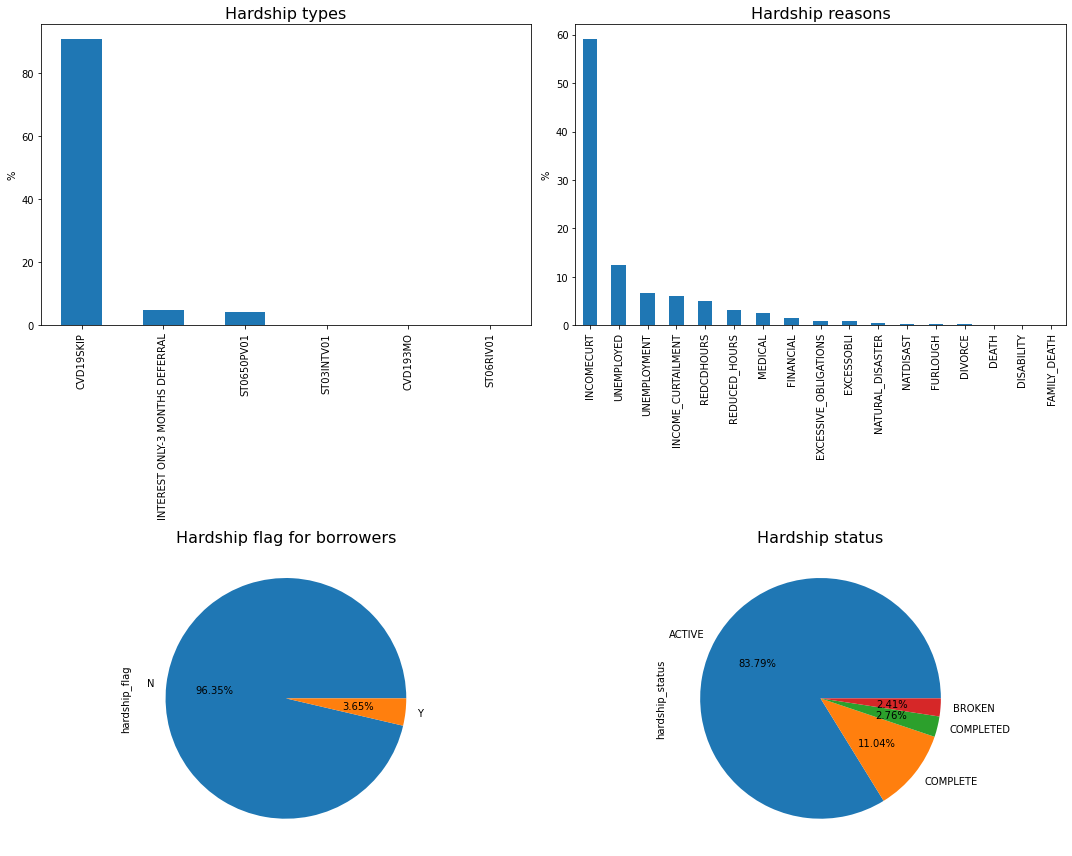

In [32]:
# Plot hardship_type, hardship_reason, and hardship_flag
fig, axs = plt.subplots(2, 2, figsize=(15,12))

# 1st plot
df['hardship_type'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0,0])
axs[0,0].set_title('Hardship types', fontsize=16)
axs[0,0].set_ylabel("%")

# 2nd plot
df['hardship_reason'].value_counts(normalize=True).mul(100).plot.bar(ax=axs[0,1])
axs[0,1].set_title('Hardship reasons', fontsize=16)
axs[0,1].set_ylabel("%")

# 3rd plot
df['hardship_flag'].value_counts().plot.pie(ax=axs[1,0], autopct='%.2f%%')
axs[1,0].set_title('Hardship flag for borrowers', fontsize=16)

# 4th plot
df['hardship_status'].value_counts().plot.pie(ax=axs[1,1], autopct='%.2f%%')
axs[1,1].set_title('Hardship status', fontsize=16)
plt.tight_layout()

* Hardship payment is the program providing a chance to people who are struggling to meet your basic needs or bear young/small children. There are 9 hardship types offered by LendingClub. There is little information about this so we will not do more analysis on hardship_type.

* The second graph shows the reason for the hardship. The main reasons why borrowers apply to a hardship plan are income curtailment (nearly 60%) and being unemployed (about 12%). 

* The 2 last graphs: There is only 3.65% of applicants enroll into hardship program. Among these, at the time of exporting data 84% of hardship plans is active, the rest of 15% includes pending, canceled, completed, and broken status.

## Bivariate EDA

In this part we will try to answer some questions related to the relationship between 2 variables.

### Loan status

#### loan_status and term

In [33]:
# create a crosstab to count the frequency of terms in each loan status
pd.crosstab(df['loan_status'], df['term'], normalize="index").mul(100)
# unit: percentage

term                                                  36 months   60 months
loan_status                                                                
Charged Off                                           61.415946   38.584054
Current                                               65.651968   34.348032
Default                                               56.842105   43.157895
Does not meet the credit policy. Status:Charged Off   85.282523   14.717477
Does not meet the credit policy. Status:Fully Paid    89.989940   10.010060
Fully Paid                                            78.679403   21.320597
In Grace Period                                       61.435662   38.564338
Late (16-30 days)                                     65.988372   34.011628
Late (31-120 days)                                    59.720280   40.279720

Text(0, 0.5, '%')

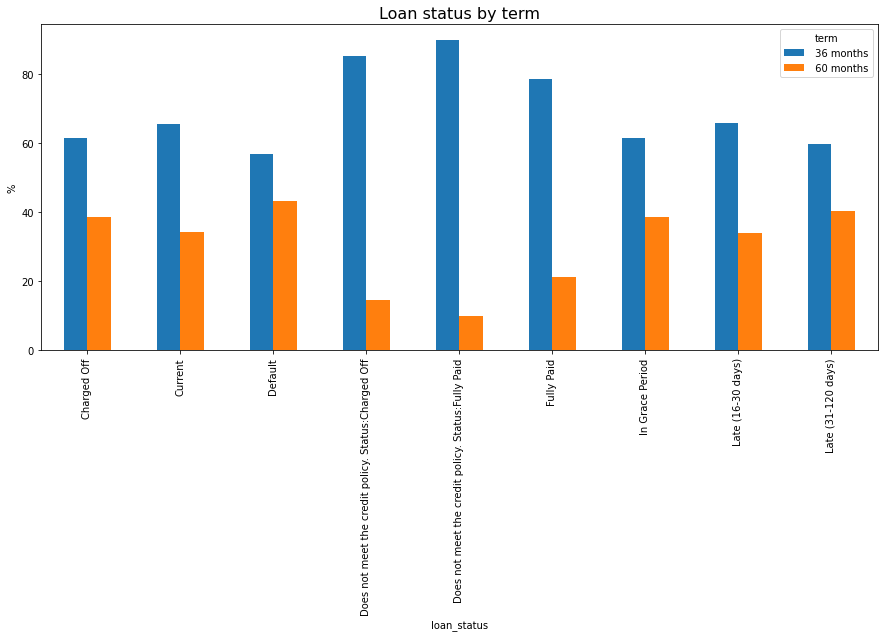

In [34]:
# visualize from crosstab
pd.crosstab(df['loan_status'], df['term'], normalize="index").mul(100).plot(kind='bar')
plt.title('Loan status by term', fontsize=16)
plt.ylabel('%')

The graph shows that the loan term of 36 months are more than twice as many as the loan term of 60 months for the people who hold status of Charged Off, Current, Default, In Grace Period and Late. Meanwhile, in the status of 'Does not meet the credit policy. Status:Charged Off' and 'Does not meet the credit policy. Status:Fully Paid', the number of applications with 36 month term is significantly higher than that of 60 month term. In general, the number of the 36 month term application is always less than the 60 month term application in each loan status. 

#### loan_status and grade

Text(0, 0.5, '%')

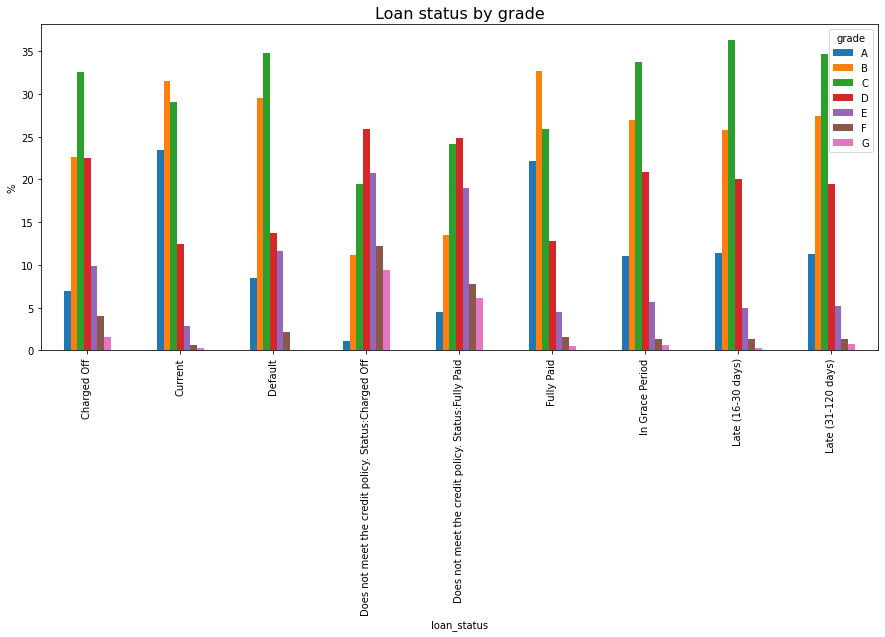

In [35]:
# the frequency of crosstab already converted into percentage
pd.crosstab(df['loan_status'], df['grade'], normalize='index').mul(100).plot(kind='bar', stacked=False)
plt.title('Loan status by grade', fontsize=16)
plt.ylabel('%')

* The graph show clearly that in the categories of Charged Off, Default, In Grace Period and Late, there is the same pattern of the percentage of grades. The highest percentage is C grade, followed by B or D. 

* Note that the order of alphabet from A to G also presents the increasing risk/ interest rate of the loan, so it is understandable why most the loan will fall into four first grades of A, B, C and D.

(Source: Rate Information. Lendingclub. https://www.lendingclub.com/foliofn/rateDetail.action. Last access 15.02.2022)

#### loan_status and home_ownership

In [36]:
# create crosstab with normalized data in each loan status
pd.crosstab(df['loan_status'], df['home_ownership'], normalize='index').mul(100)
# unit: percentage

home_ownership                                            ANY   MORTGAGE  \
loan_status                                                                
Charged Off                                          0.004189  42.737021   
Current                                              0.003793  47.492651   
Default                                              0.000000  49.473684   
Does not meet the credit policy. Status:Charged Off  0.000000  45.729304   
Does not meet the credit policy. Status:Fully Paid   0.000000  45.674044   
Fully Paid                                           0.003393  50.971657   
In Grace Period                                      0.038183  46.200840   
Late (16-30 days)                                    0.000000  44.767442   
Late (31-120 days)                                   0.023310  42.027972   

home_ownership                                           NONE     OTHER  \
loan_status                                                               
Charged Off                                          0.007330  0.028273   
Current                                              0.000000  0.000000   
Default                                              0.000000  0.000000   
Does not meet the credit policy. Status:Charged Off  0.131406  1.445466   
Does not meet the credit policy. Status:Fully Paid   0.201207  1.358149   
Fully Paid                                           0.010179  0.030536   
In Grace Period                                      0.000000  0.000000   
Late (16-30 days)                                    0.000000  0.000000   
Late (31-120 days)                                   0.000000  0.000000   

home_ownership                                             OWN       RENT  
loan_status                                                                
Charged Off                                          11.094473  46.128715  
Current                                              12.801328  39.702229  
Default                                              14.736842  35.789474  
Does not meet the credit policy. Status:Charged Off   6.438896  46.254928  
Does not meet the credit policy. Status:Fully Paid    6.941650  45.824950  
Fully Paid                                           10.154766  38.829471  
In Grace Period                                      13.440244  40.320733  
Late (16-30 days)                                    11.337209  43.895349  
Late (31-120 days)                                   13.449883  44.498834

It can be seen from the table that in each loan status, number of people having house mortgages are always majority, accounting for around 46% on average. 

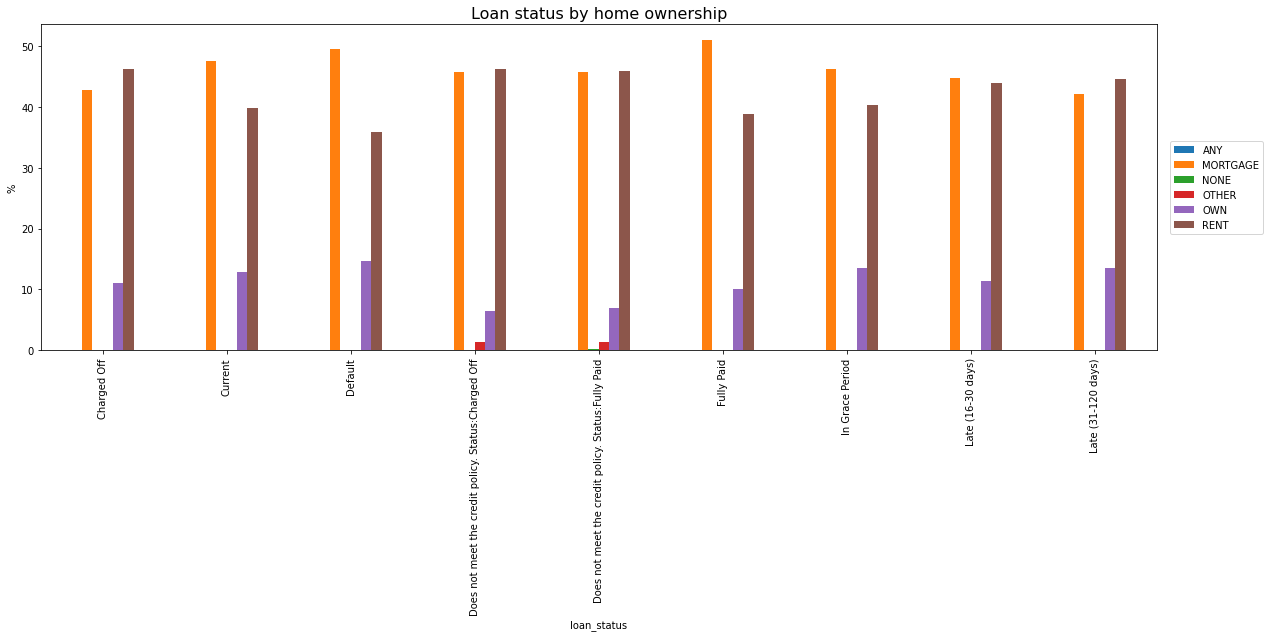

In [37]:
# visualize from the crosstab table
pd.crosstab(df['loan_status'], df['home_ownership'], normalize='index').mul(100).plot(kind='bar', figsize=(20, 6))
plt.title('Loan status by home ownership', fontsize=16)
plt.ylabel('%')
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='right')

* Only in the categories of Charged Off and Late (31-120 days) the percentage of people who rent houses are larger than the people have houses with mortgages. Meanwhile, the percentage of people who rent houses is nearly equal to that of having houses with mortgage, and in the other loan status, 'Mortgage' is more frequently observed than 'Rent'.
* In conclusion, it is hard to conclude if there is a specific type of house ownership having a significant effect on a loan status.

#### loan_status and verification_status

In [38]:
# create crosstab with normalized data in each loan status
pd.crosstab(df['loan_status'], df['verification_status'], normalize='index').mul(100)

verification_status                                  Not Verified  \
loan_status                                                         
Charged Off                                             28.170223   
Current                                                 39.809862   
Default                                                 33.684211   
Does not meet the credit policy. Status:Charged Off     67.148489   
Does not meet the credit policy. Status:Fully Paid      66.448692   
Fully Paid                                              37.223875   
In Grace Period                                         31.844215   
Late (16-30 days)                                       30.377907   
Late (31-120 days)                                      32.214452   

verification_status                                  Source Verified  \
loan_status                                                            
Charged Off                                                33.967204   
Current                                                    37.855382   
Default                                                    35.789474   
Does not meet the credit policy. Status:Charged Off        10.775296   
Does not meet the credit policy. Status:Fully Paid         10.462777   
Fully Paid                                                 30.503967   
In Grace Period                                            40.969836   
Late (16-30 days)                                          40.552326   
Late (31-120 days)                                         41.188811   

verification_status                                   Verified  
loan_status                                                     
Charged Off                                          37.862573  
Current                                              22.334756  
Default                                              30.526316  
Does not meet the credit policy. Status:Charged Off  22.076216  
Does not meet the credit policy. Status:Fully Paid   23.088531  
Fully Paid                                           32.272158  
In Grace Period                                      27.185949  
Late (16-30 days)                                    29.069767  
Late (31-120 days)                                   26.596737

Text(0, 0.5, '%')

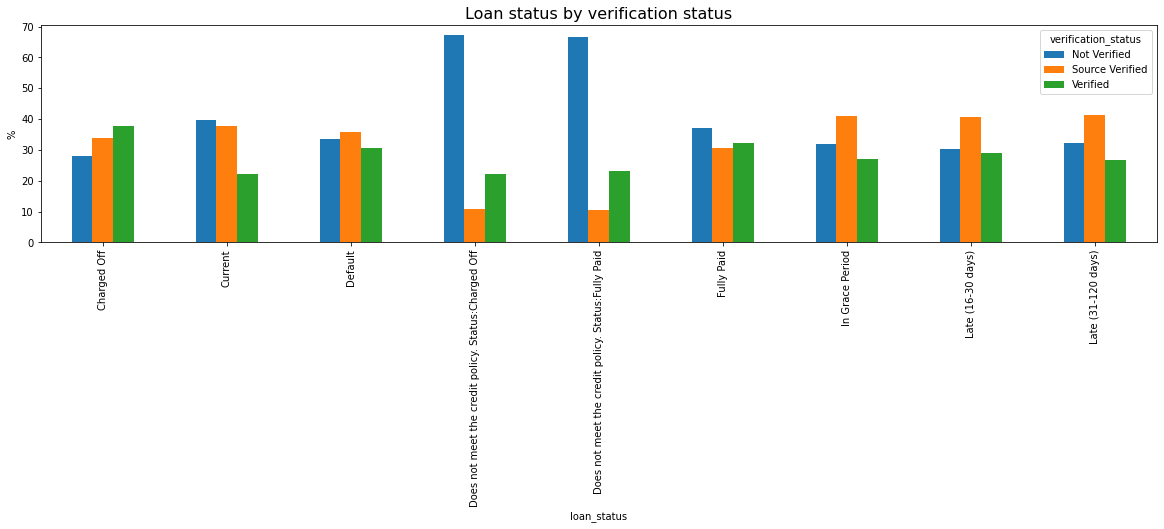

In [39]:
# visualize
pd.crosstab(df['loan_status'], df['verification_status'], normalize='index').mul(100).plot(kind='bar', figsize=(20, 4))
plt.title('Loan status by verification status', fontsize=16)
plt.ylabel('%')

* About 28% of people who have Charged Off status have the income unverified. This means that even with income verified, a person can still have the incapacity of paying back a loan.
* Late(16-30 days), Late(31-120 days), and In Grace Period categories have a similar pattern that the percentage of Not verified is nearly equal to that of Source verified. 
* In conclusion, income verification is one of the factors to consider for loan applications. We cannot conclude that with unverified income a person cannot fully pay back his/her loan. 

#### loan_status and annual_inc_range, emp_length, and purpose

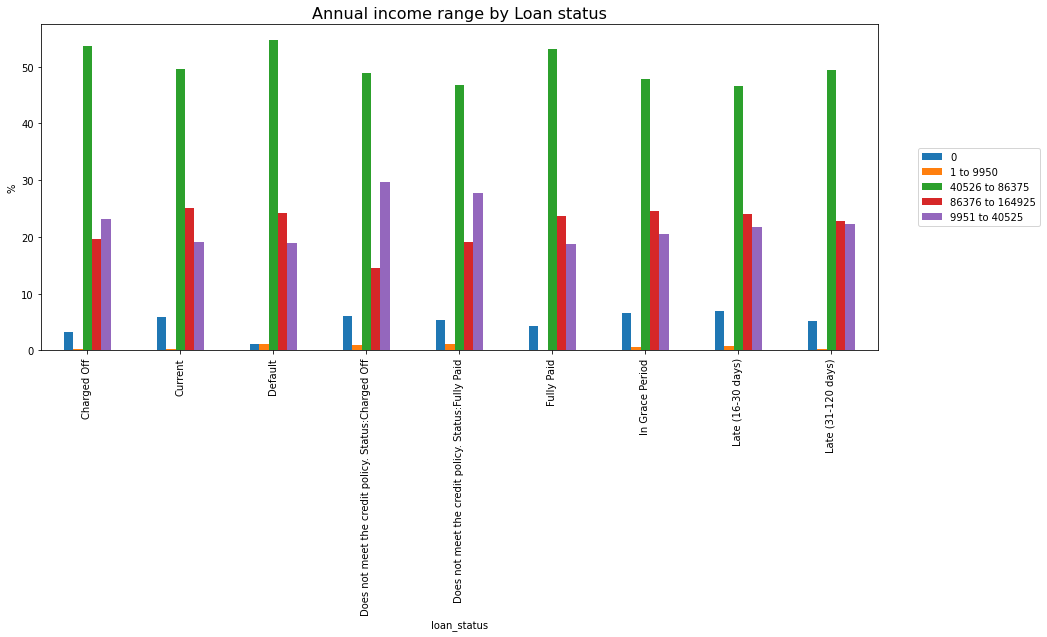

In [40]:
# Loan status and annual income range
pd.crosstab(df['loan_status'], df['annual_inc_range'], normalize='index').mul(100).plot(kind='bar')
plt.title('Annual income range by Loan status', fontsize=16)
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right')

* People who have incomes between 40526 and 86375 USD account for the highest percentage in each loan status, at about 50% on average. It is noticeable that previously people having these incomes are also the majority in the total of applicants in the sample. 
* We cannot conclude that higher income will have less chance to fall into the status of Charged Off, Default or Late.

In [41]:
# loan status and employment length
pd.crosstab(df['loan_status'], df['emp_length'], normalize='index').mul(100).plot(kind='bar')
plt.title('Employment length by Loan status', fontsize=16)
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.1, 0.5), loc='right')

People who have more than 10 years of employment take up to about 32% on average in each loan status (not consider the case of Does not meet the credit policy). A similar pattern among different loan status is observed, with the fact that the percentage of people who apply for a loan without working or less than 1-year working comes in second place at around 10% in each category of status. 

In [42]:
# loan status and purposes
pd.crosstab(df['loan_status'], df['purpose'], normalize='index').mul(100).plot(kind='bar')
plt.title('Purpose of loan in each loan status', fontsize=16)
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right')

People who apply for loans because of debt consolidation are majority in each category, so it cannot confirmed that a purpose can have a great effect on the capacity of pay back loan or not. It is just the common reason why people find LendingClub to get loans. Credit card is the second common reason, which is also related to financial reason.

Text(0.5, 0.98, 'Distribution of Annual income range, Employment length and Purpose in Charged Off status (respectively)')

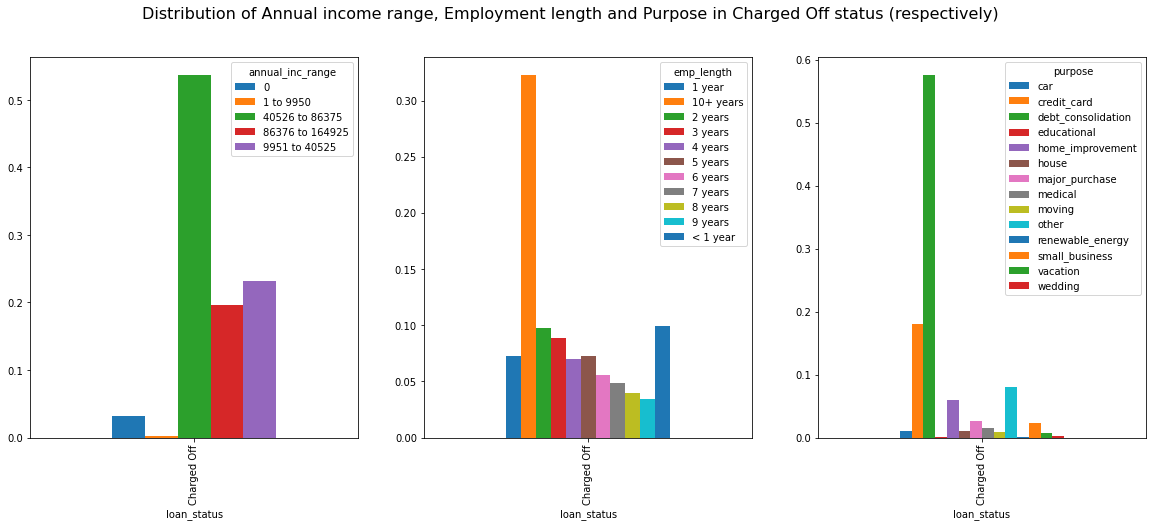

In [43]:
# a closer look at Charged Off status only
fig, axs = plt.subplots(1, 3, figsize=(20, 7), sharex=True)
pd.crosstab(df['loan_status'], df['annual_inc_range'], normalize='index').filter(items=['Charged Off'], axis=0).plot(kind='bar',ax=axs[0])
pd.crosstab(df['loan_status'], df['emp_length'], normalize='index').filter(items=['Charged Off'], axis=0).plot(kind='bar',ax=axs[1])
pd.crosstab(df['loan_status'], df['purpose'], normalize='index').filter(items=['Charged Off'], axis=0).plot(kind='bar',ax=axs[2])
fig.suptitle('Distribution of Annual income range, Employment length and Purpose in Charged Off status (respectively)', fontsize=16)

From these above graphs, it can be drawn that a person even has a good annual income (from 40526 to 86375 USD), has more than 10 year employment and may apply for any purposes above can be still fall into Charged Off status.

#### loan_status and open_acc/ total_acc

In this part only Charged Off and Fully Paid in loan status are focused on.

In [44]:
# create cross table with normalized values
df_1 = pd.crosstab(df['loan_status'], df['open_acc'], normalize='index').mul(100).sort_values(axis=1, by='Charged Off', ascending=False)
df_2 = pd.crosstab(df['loan_status'], df['total_acc'], normalize='index').mul(100).sort_values(axis=1, by='Charged Off', ascending=False)

In [45]:
fig, axs = plt.subplots(4, 1, figsize=(20, 15))

# plot the sorted value from smallest to largest order
# the index of 0 or 5 is the order of Charged Off and Fully Paid columns in the crosstab table 
df_1.sort_values(axis=1, by='Charged Off').iloc[0,:].plot.bar(ax=axs[0], color=['b', 'g'])
df_1.sort_values(axis=1, by='Fully Paid').iloc[5,:].plot.bar(ax=axs[1], color=['y', 'r'])
df_2.sort_values(axis=1, by='Charged Off').iloc[0,:].plot.bar(ax=axs[2], color=['b', 'g'])
df_2.sort_values(axis=1, by='Fully Paid').iloc[5,:].plot.bar(ax=axs[3], color=['y', 'r'])

# set title for each graphs
axs[0].set_title("Percentage of Charged Off status by the number of open credit lines in the borrower's credit file", fontsize=16)
axs[1].set_title("Percentage of Fully Paid loan status by the number of open credit lines", fontsize=16)
axs[2].set_title("Percentage of Charged Off loan status by the total number of credit lines currently in the borrower's credit file", fontsize=16)
axs[3].set_title("Percentage of Fully Paid loan status by the total number of credit lines ", fontsize=16)

# set y_axis title
axs[0].set_ylabel("Percentage")
axs[1].set_ylabel("Percentage")
axs[2].set_ylabel("Percentage")
axs[3].set_ylabel("Percentage")

fig.tight_layout()

* Two first graph: Regardless of people who are listed as Charged Off or Fully Paid, the most popular numbers of open credit lines in the borrower's credit file are from 8 to 10.
* Two second graph: The highest total number of credit lines currently in the borrower's credit file in Charged Off category is 16 and 17, while this number for Fully Paid category are 18 and 19.
* In general, people who have 30 credit lines are rare in the sample. Additionally, it cannot be concluded that there is a relationship about that having less/more credit lines (a borrowing limit) can clearly affect the ability to pay off loan.

##### loan_status and pub_rec/ pub_rec_bankruptcies

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10)) 

# loan status and number of derogatory public records
pd.crosstab(df['loan_status'], df['pub_rec']).plot(kind='bar',ax=axs[0], stacked=True)
axs[0].set_title('Number of derogatory public records by loan status', fontsize=16)
axs[0].set_ylabel("Frequency")
axs[0].legend(bbox_to_anchor=(1.05, 0.6), loc='right')

# loan status and number of public record bankruptcies
pd.crosstab(df['loan_status'], df['pub_rec_bankruptcies']).plot(kind='bar',ax=axs[1], stacked=True)
axs[1].set_title('Number of public record bankruptcies by loan status', fontsize=16)
axs[1].set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

There are a high similarity between 2 graphs about the negative behavioral payments. It can be seen that majority of the applicants have no public records of derogatory or bankruptcies.

#### Loan status and interest rate / loan amount

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# loan status and interest rate
sns.boxplot(x="loan_status", y="int_rate", data=df, color='g', ax=axs[0])
axs[0].set_title('Loan Status by Interest Rate', fontsize=16)

# loan status and loan amount
sns.boxplot(x="loan_status", y="loan_amnt", data=df, color='orange', ax=axs[1])
axs[1].set_title('Loan Status by Loan Amount', fontsize=16)
axs[1].tick_params(axis='x', rotation=90)

From both graphs we can see that:
* People who are in status of Charged Off and Default also the ones who hold a high interest rate (at about 15% on average). Meanwhile, the average of loan amount in these two status (at aroud 15000 USD) are pretty the same as that in other status except Fully Paid.
* People who can fully pay off loans have lower interest rate (around 13%) and lower amount of loan (about 12000 USD) compared to people with other status.

#### Loan status per state 

In [48]:
# create crosstab
df_st = pd.crosstab(df['loan_status'], df['addr_state'], normalize='index')

In [49]:
# visualize the above data
fig, axs = plt.subplots(2, 1, figsize=(15, 7))

df_st.sort_values(axis=1, by='Charged Off').iloc[0,:].plot.bar(ax=axs[0], color=['b', 'g'])
axs[0].set_title('Percenage of Charged Off status per state', fontsize=16)
axs[0].set_ylabel("%")

df_st.sort_values(axis=1, by='Fully Paid').iloc[5,:].plot.bar(ax=axs[1], color=['y', 'r'])
axs[1].set_title('Percenage of Fully paid status per state', fontsize=16)
axs[1].set_ylabel("%")
fig.tight_layout()

States where applicants come from may not help to predict the probability of paying back loan, since it can be seen that while some states like CA, TX, FL, NY, IL and NJ have the highest number of people who are successful pay off as well as the highest number of people holding the status of Charged Off.

### Loan amount 

#### Loan amount vs year experience 

In [50]:
# crosstab table that count frequency of employment length per loan amount range
# unit: percentage
df_emp = pd.crosstab(df['loan_amnt_range'], df['emp_length'], normalize='index').mul(100)
df_emp

emp_length         1 year  10+ years    2 years   3 years   4 years   5 years  \
loan_amnt_range                                                                 
460-6143         8.419218  29.358200  11.264545  9.458747  7.384553  7.194810   
6143-11786       7.584134  31.102433  10.561417  9.192579  7.240114  7.526797   
11786-17429      6.786177  34.410909   9.547376  8.575292  6.745113  7.271865   
17429-23071      6.204667  37.747343   8.736715  7.858004  6.164128  6.876301   
23071-28714      5.742543  40.032966   8.305418  7.513160  6.011946  6.561387   
28714-34357      5.672077  39.999392   8.629704  7.334792  5.893975  6.304335   
34357-40000      5.489590  40.174243   8.185203  7.833907  6.063374  6.210918   

emp_length        6 years   7 years   8 years   9 years   < 1 year  
loan_amnt_range                                                     
460-6143         5.263329  4.361646  3.487533  3.107237  10.700182  
6143-11786       5.558640  4.755927  3.766115  3.404592   9.307252  
11786-17429      5.392834  4.912810  3.925858  3.681598   8.750168  
17429-23071      5.494686  4.930426  3.925715  3.679194   8.382820  
23071-28714      5.164744  4.542635  3.755694  3.617447   8.752060  
28714-34357      5.015502  4.346769  3.547328  3.489574   9.766551  
34357-40000      4.630085  4.295183  3.536383  3.461439  10.119675

* The table indicates that there is a similar pattern in each loan amount range: people who have more than 10 year employment account for the most (within the range from 29% to 40%), which generally is triple the number of people who have less than 1 year employment, and people with employment length from 1 to 9 years will account for less than 10% (each).
* There is no clear answer to the question that a long lasting employed people will tend to apply for the high or low loan amount.

#### Loan amount and term

In [51]:
# plot using sns box plot
sns.boxplot(x='term', y='loan_amnt', data=df, palette="Blues")
plt.title('Loan amount distribution by term', fontsize=16)

Text(0.5, 1.0, 'Loan amount distribution by term')

The box plot graph above shows that the mean of 60 month loan amount (20000 USD) is higher than the mean of 36 month loan amount (10000 USD), which is reasonable that higher amounts of loan require longer time to be paid.

#### Loan amount and purpose

Text(0, 0.5, '%')

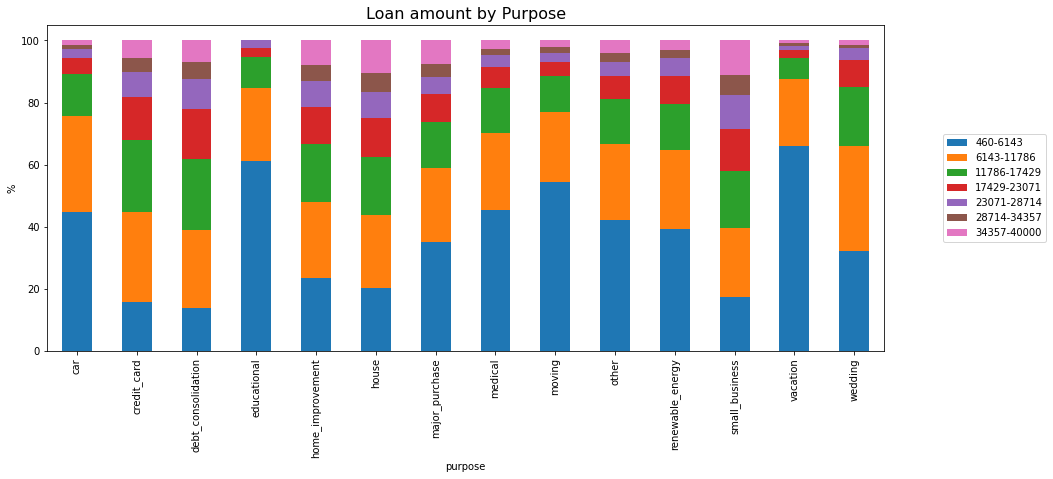

In [52]:
# plot graph using crosstab
pd.crosstab(df['purpose'], df['loan_amnt_range'], normalize='index').mul(100).plot(kind='bar', stacked=True)
plt.title('Loan amount by Purpose', fontsize=16)
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right')
plt.ylabel('%')

* For car, educational, major_purchase, medical, moving, renewable energy, and vacation purpose, most people apply for loan amount range from 460 to 6143 USD. 
* For the purposes of credit card, debt_consolidation, home_improvement, house, small business and wedding, the range of 6143-11786 USD is often applied to, which implies that these activities need more money than others. 

In [53]:
# distribution plot 
sns.boxplot(x='purpose', y='loan_amnt', data=df, palette="Accent")
plt.title("Loan amount distribution by purpose", fontsize=16)
plt.ylabel('Loan amount in USD')
plt.tick_params(axis='x', rotation=90)

* Compared the highest and lowest average loan amount among categories: People need around 15000 USD on average for the purpose of small business and debt_consolidation, while for vacation and educational purposes the amount of around 5000 USD is on request.

### Purpose

#### Purpose and term

Text(0, 0.5, '%')

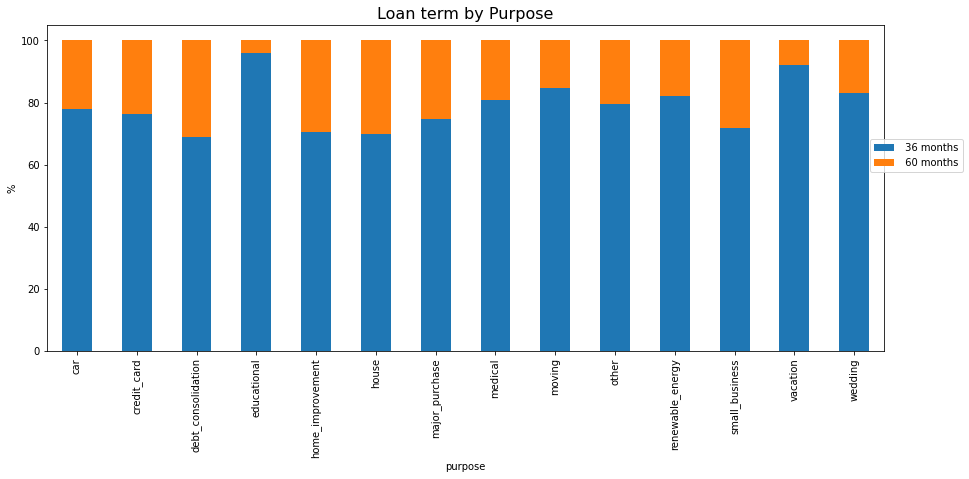

In [54]:
# plot from crosstab
pd.crosstab(df['purpose'], df['term'], normalize='index').mul(100).plot(kind='bar', stacked=True)
plt.title('Loan term by Purpose', fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 0.6), loc='right')
plt.ylabel('%')

For each purpose, most of the loan term is 36 months. Especially, for educational purpose the number of 60 month loan is only about 5%. 

#### Purpose and grade

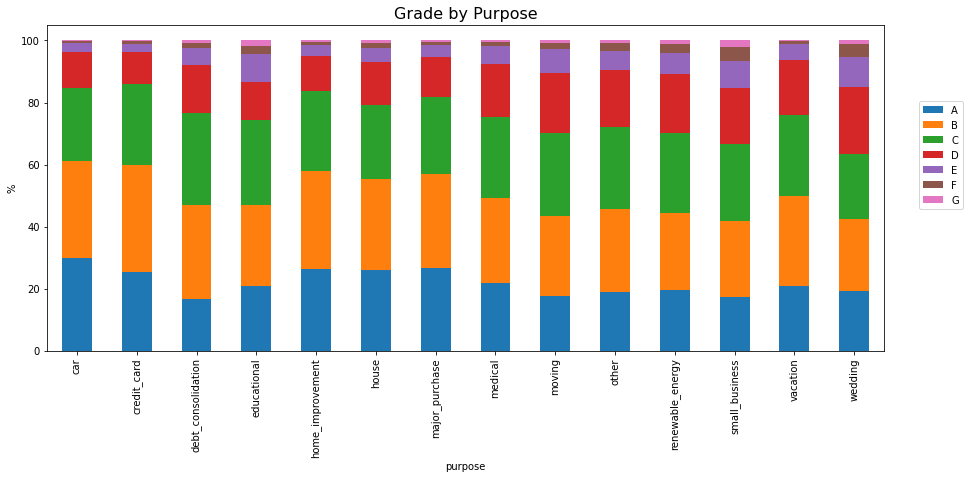

In [55]:
# purposes of loan and loan grades
pd.crosstab(df['purpose'], df['grade'], normalize='index').mul(100).plot(kind='bar', stacked=True)
plt.title('Grade by Purpose', fontsize=16)
plt.ylabel('%')
plt.legend(bbox_to_anchor=(1.1, 0.6), loc='right')

Overall, A, B , C are the most popular loan grade and it can be seen that there is no special relationship between loan purposes and assigned grades since in each purpose, the percentage of loan grades are not significantly differently from each other.

### Interest rate

#### Interest rate and annual income

Text(0, 0.5, '%')

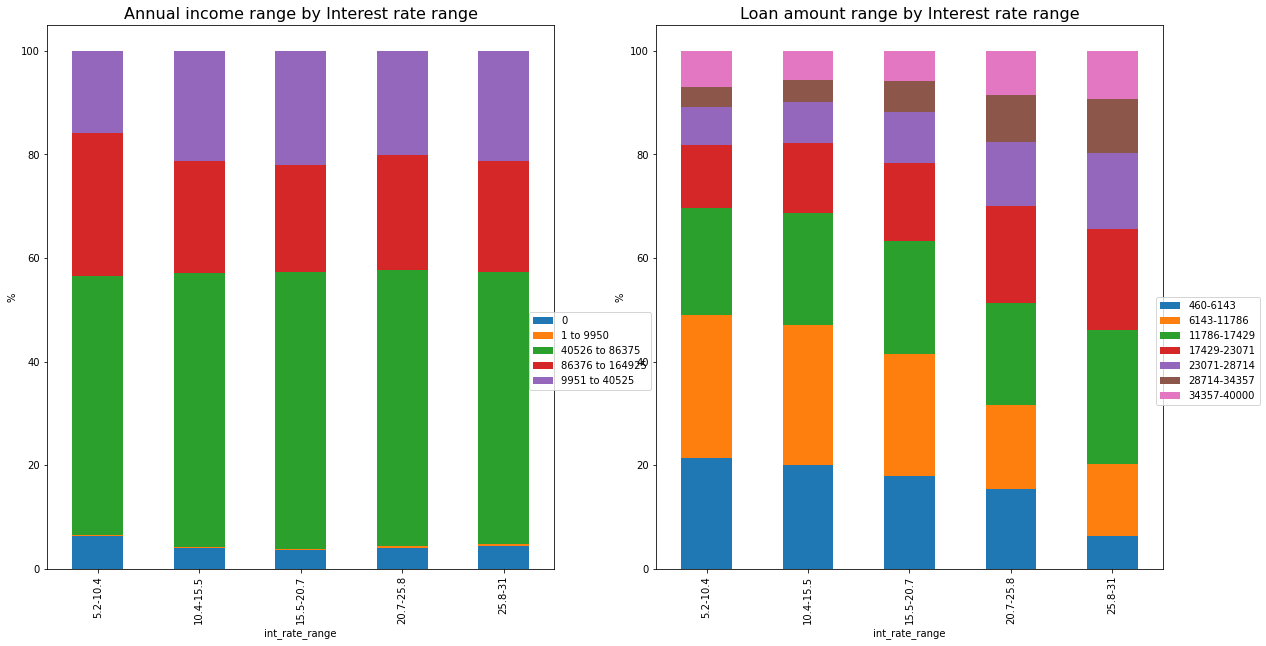

In [56]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# interest rate range and annual income range
pd.crosstab(df['int_rate_range'], df['annual_inc_range'], normalize='index').mul(100).plot(kind='bar', ax=axs[0], stacked=True)
axs[0].set_title('Annual income range by Interest rate range', fontsize=16)
axs[0].legend(bbox_to_anchor=(1.2, 0.4), loc='right')
axs[0].set_ylabel('%')

# Loan amount range and interest rate range
pd.crosstab(df['int_rate_range'], df['loan_amnt_range'], normalize='index').mul(100).plot(kind='bar', ax=axs[1], stacked=True)
axs[1].set_title('Loan amount range by Interest rate range', fontsize=16)
axs[1].legend(bbox_to_anchor=(1.2, 0.4), loc='right')
axs[1].set_ylabel('%')

* The first graph indicates that people whose income range from 40526 to 86375 USD are account for around 50% of the people in each interest range. We can observe the similar pattern in each categories of interest range. It is lack of evidence to conclude that a person with higher income will have a specific trend to apply more for a higher or lower risk loan.

* The right graph shows that people apply low loan amounts (from 460-6143 USD) less likely to accept high interest rate loan from 25.8%-31%, which makes sense in practice. The people who apply for loan amount in the range of 6143-11786 USD are majority in low interest rate range in general. It can be seen that the proportion of these people is high in interest range of 5.2%-10.4%, but decreases when the interest rate ranges increase.

#### Interest rate and term

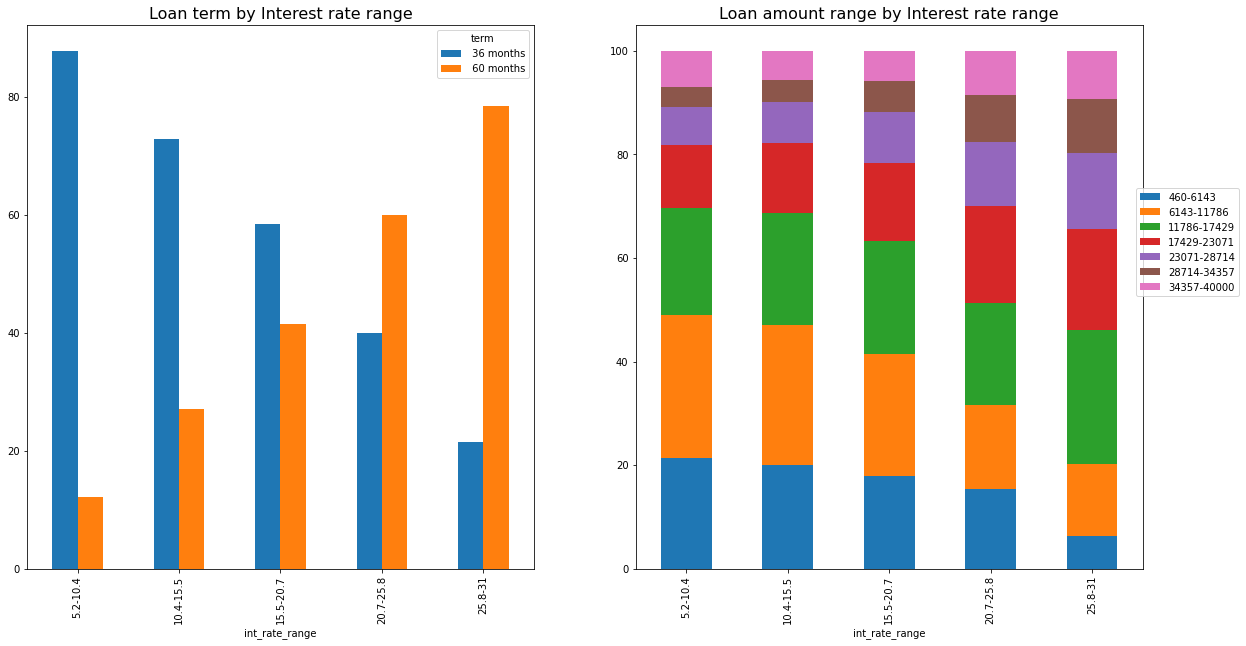

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# plot
pd.crosstab(df['int_rate_range'], df['term'], normalize='index').mul(100).plot(kind='bar', ax=axs[0], stacked=False)
pd.crosstab(df['int_rate_range'], df['loan_amnt_range'], normalize='index').mul(100).plot(kind='bar', ax=axs[1], stacked=True)

# set titles
axs[0].set_title('Loan term by Interest rate range', fontsize=16)
axs[1].set_title('Loan amount range by Interest rate range', fontsize=16)
axs[1].legend(bbox_to_anchor=(1.2, 0.6), loc='right')

* It is evidenced from the left graph that in low range of interest rate (5.2%-10.4%) the people apply for 36 month loan is popular (87%) while people who apply for 60 month term with low interest rates account only (13%). However, when a person apply for high interest rate loan, he/she mostly chooses the long term of 60 months instead of 36 month. 

* From the right graph we cannot conclude a relationship between loan amount range and interest rate range, because no specific pattern found.

#### Interest vs sub-grade 

Each grade have coresponding interest to Grade which is mentrion at LendingClub website:

(https://www.lendingclub.com/investing/investor-education/interest-rates-and-fees. Last access 15.02.2022)

Text(0.5, 1.0, 'Interest rate distribution by Grade')

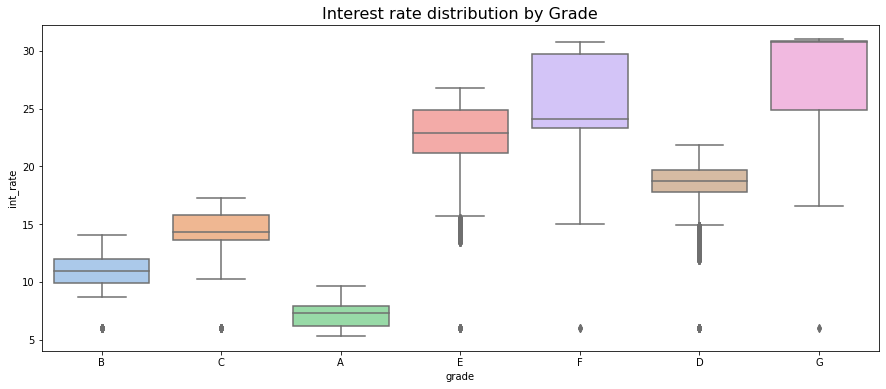

In [58]:
# plot the distribution of interest rate in each loan grade
sns.boxplot(x='grade', y='int_rate', data=df, palette="pastel")
plt.title("Interest rate distribution by Grade", fontsize=16)

* Grades given the highest interest rates are G, F and E (in descending order), respectively with mean at 22%, 24%, and 27%. These loan grades show higher levels of risk than the rest of the loans therefore higher interest rates are assigned to them.
* Groups of grades with lowest interest rate are A, B, C (in descending order), respectively with mean at 7%, 11% and 15%. 
* There is no interest rate below 5% because LendingClub set the base rate for every loan at 5.05%. 

(Source: Rate Information. Lendingclub. https://www.lendingclub.com/foliofn/rateDetail.action. Last access 15.02.2022)

In [59]:
# remove the columns that do not involve in the model
df.drop(columns=['loan_amnt_range', 'int_rate_range', 'annual_inc_range', 'FICO_rating'], inplace=True)

### Pearson correlation matrix

In [60]:
# Create Pearson correlation with absolute values
corr_table = df.corr().abs()

In [61]:
# drop_duplicates() may drop all correlation with a variables itself except the fisrt duplicate (loan_amount), we will check the heat map later
# filter out the pair of features which have a correlation value larger than 0.7
corr_table[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt                       loan_amnt                                     1.000000
sec_app_fico_range_low          sec_app_fico_range_high                       1.000000
out_prncp_inv                   out_prncp                                     1.000000
num_sats                        open_acc                                      0.999278
funded_amnt                     loan_amnt                                     0.999253
total_pymnt_inv                 total_pymnt                                   0.998082
funded_amnt                     funded_amnt_inv                               0.998002
loan_amnt                       funded_amnt_inv                               0.997082
num_actv_rev_tl                 num_rev_tl_bal_gt_0                           0.985851
tot_hi_cred_lim                 tot_cur_bal                                   0.977287
total_rec_prncp                 total_pymnt                                   0.957634
                                total_pymnt

It can be seen that there are many pairs of variables have correlation of 1 or nearly 1. Some of the variables appeared in the list should be remove to make sure that the algorithms have less struggles while training the data and avoid dilute information.

## Conclusion of EDA

In this part of Exploratory data analysis, there are some charateristics of LendingClub applicants canbe noticed:

* Overall, most of the people come to LendingClub with a good profile (good average FICO scores and no public records of bankruptcies). They need loans because of their financial reasons (Debt consolidation and credit card).

* Most people have a shorter loan term (36 months, compared to 60 months) and do not enroll into the hardship plan, but the percentage of people who are Charged Off and default accounts for nearly one third of the data sample.

* Checking bivariance relationship cannot show that the features such as annual income, verified status, house ownership, credit line, etc. have a specific effect on Charged Off, Default or Late status.

* People with lower interest rate and lower loan amount likely to pay off loans successfully.

## Data prepration

### Cleaning columns
Based on the exploratory data analysis part, there are columns should be removed with below reasons.

#### Reason 1: Unrelated information
Columns have less usefull information related to the purpose of this project

In [62]:
df.filter(items=['url','id','zip_code','title','emp_title','inq_fi','mths_since_recent_inq', 'inq_last_6mths']).head()

url       id  \
0  https://lendingclub.com/browse/loanDetail.action?loan_id=1077501  1077501   
1  https://lendingclub.com/browse/loanDetail.action?loan_id=1077430  1077430   
2  https://lendingclub.com/browse/loanDetail.action?loan_id=1077175  1077175   
3  https://lendingclub.com/browse/loanDetail.action?loan_id=1076863  1076863   
4  https://lendingclub.com/browse/loanDetail.action?loan_id=1075358  1075358   

  zip_code                 title                 emp_title  inq_fi  \
0    860xx              Computer                       NaN     NaN   
1    309xx                  bike                     Ryder     NaN   
2    606xx  real estate business                       NaN     NaN   
3    917xx              personel       AIR RESOURCES BOARD     NaN   
4    972xx              Personal  University Medical Group     NaN   

   mths_since_recent_inq  inq_last_6mths  
0                    NaN             1.0  
1                    NaN             5.0  
2                    NaN             2.0  
3                    NaN             1.0  
4                    NaN             0.0

* id and url columns contains unique ID or url for each customers, does not have other meaning
* inq_fi: Number of personal finance inquiries by LendingClub
* mths_since_recent_inq: Months since most recent inquiry
* inq_last_6mths: The number of inquiries in past 6 months. 
* A credit inquiry is a request put up by a financial institution or firm for the credit report information of an individual from a credit reporting bureau, so it not related to characteristics of loan or behavioral payments.

Information which only served the purpose of administration like this should be removed

In [63]:
# Drop above columns
df.drop(columns=['url','id','zip_code','title','emp_title','inq_fi','mths_since_recent_inq', 'inq_last_6mths'], inplace=True)

#### Reason 2: Missing values

##### Columns have too many missing values

In [64]:
# check and calculate the percentage of null values out of the total values counted in each column
null_values = df.isnull().sum()
# len(df.index) is to count the total number of values in a columns supposed to have
percent_nullvalues = null_values/len(df.index)*100 

In [65]:
# sort the percentage of missing values from high to low
percent_nullvalues.sort_values(ascending=False, axis=0)

hardship_loan_status                          95.710714
hardship_status                               95.703429
hardship_reason                               95.703429
hardship_dpd                                  95.703143
hardship_type                                 95.703143
hardship_length                               95.703143
payment_plan_start_date                       95.703143
hardship_end_date                             95.703143
hardship_start_date                           95.703143
deferral_term                                 95.703143
orig_projected_additional_accrued_interest    94.473429
hardship_last_payment_amount                  94.385429
hardship_payoff_balance_amount                94.385429
hardship_amount                               94.385429
sec_app_revol_util                            91.011000
verification_status_joint                     90.981571
revol_bal_joint                               90.845714
sec_app_num_rev_accts                         90

A feature cannot bring much value to the prediction when it has too many null values.
Therefore, a threshold of 50% is chosen to remove all columns which have the number of missing values larger or equal to 50% of the total values in each column. 

In [66]:
# remove columns with a condition that more than 50% of the values in that column is null
df.dropna(axis=1, thresh=(1-0.50)*len(df.index), inplace=True)

#### Reason 3: Uninformative for classification
Columns bring little information for classification

Text(0.5, 0.98, 'Distribution of classes in each feature')

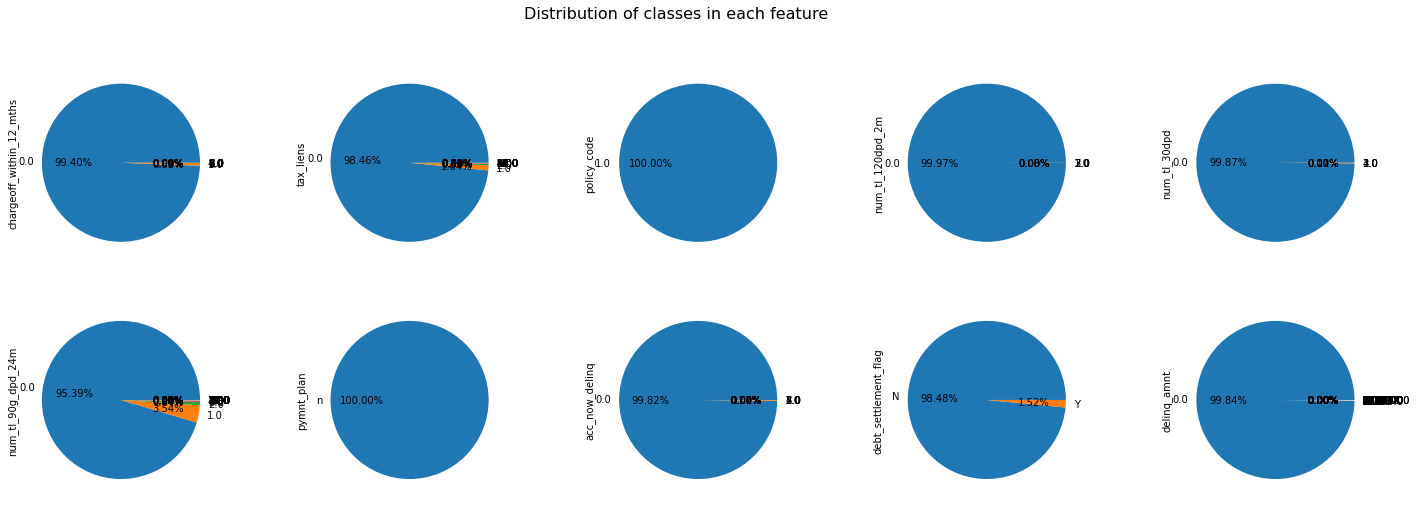

In [67]:
fig, axs = plt.subplots(2, 5, figsize=(25, 8))
# 1st row
df['chargeoff_within_12_mths'].value_counts().plot.pie(ax=axs[0,0], autopct='%.2f%%')
df['tax_liens'].value_counts().plot.pie(ax=axs[0,1],autopct='%.2f%%')
df['policy_code'].value_counts().plot.pie(ax=axs[0,2],autopct='%.2f%%')
df['num_tl_120dpd_2m'].value_counts().plot.pie(ax=axs[0,3],autopct='%.2f%%')
df['num_tl_30dpd'].value_counts().plot.pie(ax=axs[0,4],autopct='%.2f%%')
# 2ns row
df['num_tl_90g_dpd_24m'].value_counts().plot.pie(ax=axs[1,0],autopct='%.2f%%')
df['pymnt_plan'].value_counts().plot.pie(ax=axs[1,1],autopct='%.2f%%')
df['acc_now_delinq'].value_counts().plot.pie(ax=axs[1,2],autopct='%.2f%%')
df['debt_settlement_flag'].value_counts().plot.pie(ax=axs[1,3],autopct='%.2f%%')
df['delinq_amnt'].value_counts().plot.pie(ax=axs[1,4], autopct='%.2f%%')
# set title
fig.suptitle('Distribution of classes in each feature', fontsize=16)

* The pie graphs show feature contains only one value/label only (account for nearly 100%). For example, num_tl_30dpd show that 99.89% of applicants have zero accounts currently 30 days past due.
* For categorial variables that contain only one type of class or numerical variables that contain only one type of numerical data for all the applicants; The model will not use them for classification, especially for the tree-based model like XGBoost. 

In [68]:
# date and time
df_date = df.filter(items=['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d'])
df_date.head()

issue_d earliest_cr_line last_pymnt_d last_credit_pull_d
0  Dec-2011         Jan-1985     Jan-2015           May-2020
1  Dec-2011         Apr-1999     Apr-2013           Oct-2016
2  Dec-2011         Nov-2001     Jun-2014           Jun-2017
3  Dec-2011         Feb-1996     Jan-2015           Apr-2016
4  Dec-2011         Jan-1996     Jan-2017           Apr-2018

* All the columns containing information about date and time are also removed since there is no relevant data or benchmark of time to do a further examination to understand these values

Other features are mentioned below:
* initial_list_status: identifies whether a loan was initially listed in the whole (W) or fractional (F) market, bringing information from the view of investors, so it is not useful in predicting if a borrower can pay back the money to an investor or not.

* To avoid diluting the information, between grade and sub_grade, we choose to keep sub_grade only

In [69]:
df.drop(columns=['initial_list_status', 'grade', 
                 'chargeoff_within_12_mths', 'tax_liens', 'policy_code', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
                 'num_tl_90g_dpd_24m', 'pymnt_plan', 'acc_now_delinq', 'debt_settlement_flag', 'delinq_amnt', 
                 'issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d',
                ], inplace=True)

#### Reason 4: Collected data after a loan is granted

There are also columns presenting what happens after a loan is granted. They should be dropped to avoid the overfitting model. 
They are the information related to recoveries, installments, or hardship. For example, hardship_flag should be removed because it is applied as a last resort for a borrower when he/she is struggling to pay monthly installments after getting the loan. 

In [70]:
df.drop(columns=['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 'last_fico_range_low',
                 'last_fico_range_high','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','tot_coll_amt','last_pymnt_amnt',
                 'total_il_high_credit_limit', 'hardship_flag', 'installment', 
                 'revol_util','collections_12_mths_ex_med'],
                inplace=True)

#### Reason 5: High correlation - Based on Pearson correlation matrix

In [71]:
# After droping some columns, we create a new correlation table for the rest of features
cr = df.corr().abs()

# filter out the pair of features with correlation score larger than 0.7
cr[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt             loan_amnt               1.000000
num_sats              open_acc                0.999278
num_rev_tl_bal_gt_0   num_actv_rev_tl         0.985851
tot_hi_cred_lim       tot_cur_bal             0.977287
total_bal_il          total_bal_ex_mort       0.903863
total_bc_limit        bc_open_to_buy          0.858792
acc_open_past_24mths  open_rv_24m             0.850912
bc_util               percent_bc_gt_75        0.849120
num_op_rev_tl         open_acc                0.844777
open_rv_12m           num_tl_op_past_12m      0.844313
num_sats              num_op_rev_tl           0.844281
num_rev_accts         num_bc_tl               0.843111
num_bc_sats           num_actv_bc_tl          0.835555
num_actv_rev_tl       num_actv_bc_tl          0.833164
num_actv_bc_tl        num_rev_tl_bal_gt_0     0.827188
avg_cur_bal           tot_cur_bal             0.823470
num_op_rev_tl         num_rev_accts           0.799852
                      num_rev_tl_bal_gt_0     0.793955
          

In [72]:
# drop features based on the results above
df.drop(columns=['num_sats','num_rev_tl_bal_gt_0', 'tot_hi_cred_lim',
                'bc_open_to_buy', 'percent_bc_gt_75', 'total_bal_ex_mort',
                'num_rev_accts', 'num_actv_bc_tl', 'num_op_rev_tl', 
                'avg_cur_bal', 'num_tl_op_past_12m', 'open_rv_24m', 'open_il_24m',
                'pub_rec_bankruptcies', 'total_rev_hi_lim', 'num_bc_sats',
                'total_acc'], inplace=True)

In [73]:
# check again if any correlation coefficients >0.7
cr = df.corr().abs()
cr[corr_table>0.7].unstack().transpose().sort_values(ascending=False).drop_duplicates()

loan_amnt  loan_amnt    1.0
           int_rate     NaN
dtype: float64

<AxesSubplot:>

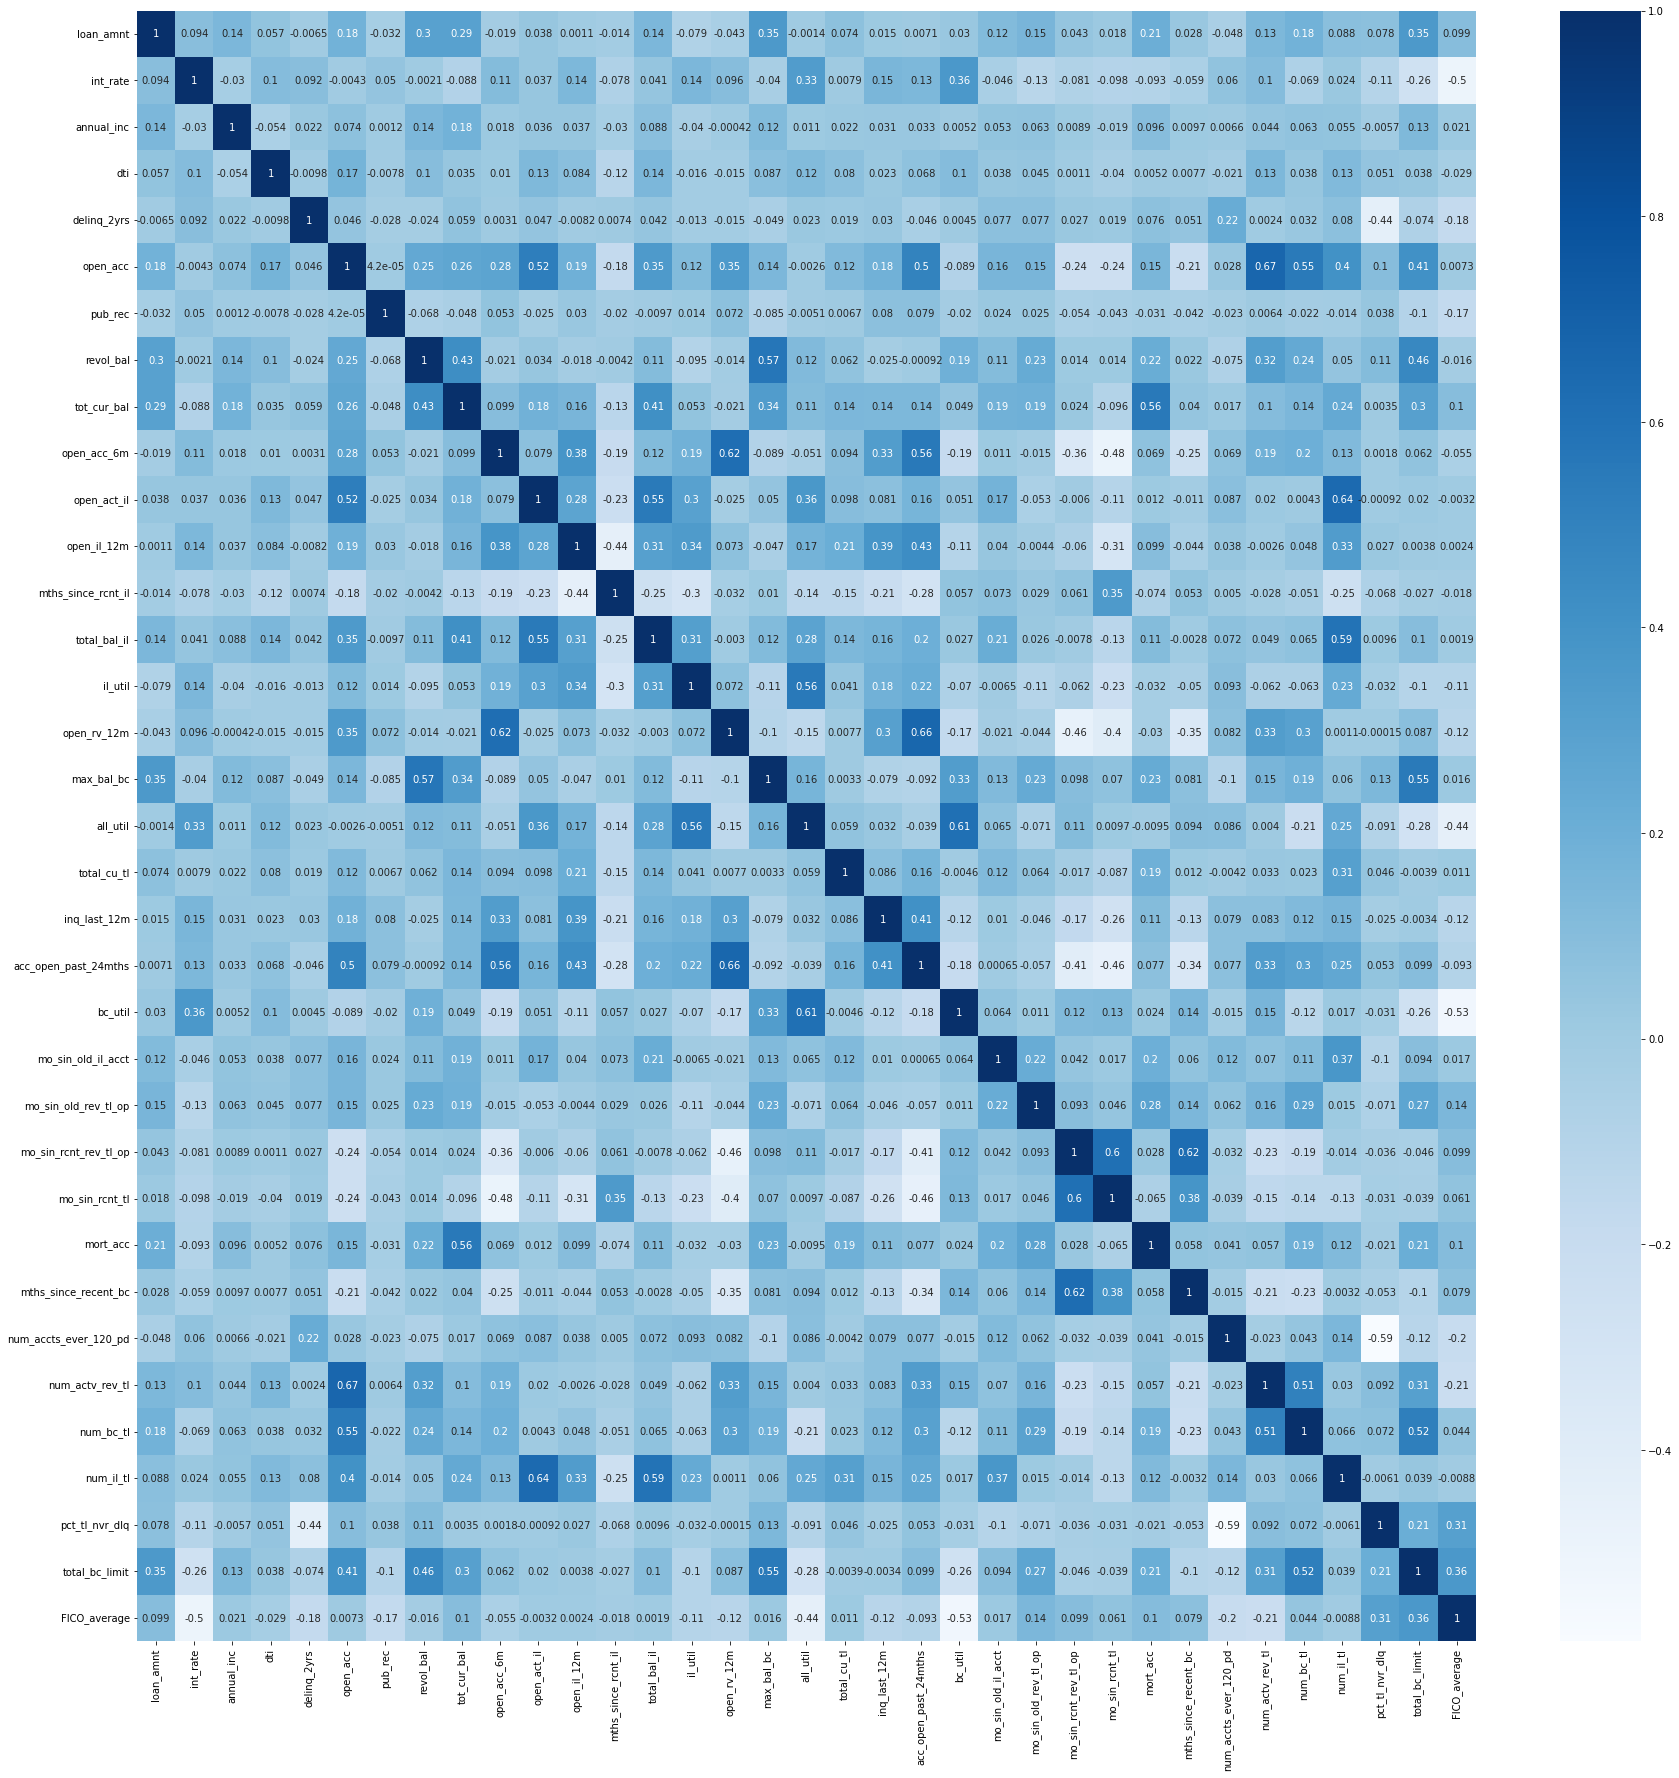

In [74]:
# final check with correlation matrix
plt.figure(figsize=(30,30))        
sns.heatmap(df.corr(), annot=True, cmap="Blues")

* The correlation matrix present the correlation among numerical features. It can be seen that all the pairs with correlation bigger than 0.7 are dropped out. 
* Note that since we are using Pearson correlation, correlation coefficients close to 0 do not mean that there is no relationship between two features. There may be a nonlinear relationship. 

### Cleaning rows

In this part duplicated values will be checked as well as all the rows containing null values will be deleted. For the XGBoost model, it may be unnecessary to clean all the rows with null values since the model itself can set these null values to 0, but for the Logistic model, it can not train the data containing NaN values. We try to obtain a data sample that both models can be trained on.

In [75]:
# check duplicated values
df.duplicated(keep='first')

0         False
1         False
2         False
3         False
4         False
          ...  
699995    False
699996    False
699997    False
699998    False
699999    False
Length: 700000, dtype: bool

In [76]:
# if the sum value is not 0, meanning there is a duplicated row
df.duplicated(keep='first').sum()

0

Conclusion: There is no rows which are exactly duplicated.

In [77]:
# drop rows with missing values
df.dropna(inplace=True)

# check missing value in rows
df.isnull().sum().sort_values()

loan_amnt                0
open_rv_12m              0
max_bal_bc               0
all_util                 0
total_cu_tl              0
inq_last_12m             0
acc_open_past_24mths     0
bc_util                  0
mo_sin_old_il_acct       0
il_util                  0
mo_sin_old_rev_tl_op     0
mo_sin_rcnt_tl           0
mort_acc                 0
mths_since_recent_bc     0
num_accts_ever_120_pd    0
num_actv_rev_tl          0
num_bc_tl                0
num_il_tl                0
pct_tl_nvr_dlq           0
mo_sin_rcnt_rev_tl_op    0
total_bal_il             0
mths_since_rcnt_il       0
open_il_12m              0
term                     0
int_rate                 0
sub_grade                0
emp_length               0
home_ownership           0
annual_inc               0
verification_status      0
loan_status              0
purpose                  0
addr_state               0
dti                      0
delinq_2yrs              0
open_acc                 0
pub_rec                  0
r

In [78]:
# check the final dimension of the dataset after cleaning
df.shape

(363496, 44)

After cleaning the dimension of the dataset are 1113364 rows and 44 columns (or 44 features). The number of columns decrease significantly, compared to the initial of 141 columns.

### Convert data types

XGBoost model only allows for int, float, or boolean data types, so we check and convert where necessary.

In [79]:
# check the data type for each feature
df.dtypes.sort_values()

loan_amnt                float64
open_rv_12m              float64
max_bal_bc               float64
all_util                 float64
total_cu_tl              float64
inq_last_12m             float64
acc_open_past_24mths     float64
bc_util                  float64
mo_sin_old_il_acct       float64
il_util                  float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcnt_tl           float64
mort_acc                 float64
mths_since_recent_bc     float64
num_accts_ever_120_pd    float64
num_actv_rev_tl          float64
num_bc_tl                float64
num_il_tl                float64
pct_tl_nvr_dlq           float64
mo_sin_rcnt_rev_tl_op    float64
total_bal_il             float64
mths_since_rcnt_il       float64
open_il_12m              float64
int_rate                 float64
annual_inc               float64
total_bc_limit           float64
dti                      float64
delinq_2yrs              float64
open_acc                 float64
FICO_average             float64
revol_bal 

We treat 'term' and 'emp_length' as categorical model for the XGBoost model. For 'term', the reason is obvious because there are only 2 types in provided from the company. For 'emp_length', the classes of 'less than 1 year' or 'more than 10 years' is hard to be precise if they are converted to numeric type.

##### Setting dummies

There are many methods but here get_dummies is used to convert categrical variables because it is fast and simple.

In [80]:
# One-hot encoding with Pandas: setting the dummies
df_xgb = pd.get_dummies(df, columns=['application_type',
                                    'addr_state',
                                    'purpose',
                                    'verification_status',
                                    'home_ownership',
                                    'emp_length',
                                    'sub_grade',
                                    'term'])
# reset index
df_xgb= df_xgb.reset_index()
# check the new data created
df_xgb.head().transpose()

0         1         2  \
index                                    230717    230718    230719   
loan_amnt                               12000.0   32000.0   40000.0   
int_rate                                   7.97     11.99     15.05   
annual_inc                              42000.0  155000.0  120000.0   
loan_status                          Fully Paid   Current   Current   
dti                                       27.74     12.35     31.11   
delinq_2yrs                                 0.0       2.0       0.0   
open_acc                                    9.0      20.0      12.0   
pub_rec                                     1.0       0.0       0.0   
revol_bal                               11457.0   48309.0   13389.0   
tot_cur_bal                             30502.0  405751.0  227506.0   
open_acc_6m                                 1.0       2.0       2.0   
open_act_il                                 2.0       1.0       3.0   
open_il_12m                                 1.0       1.0       2.0   
mths_since_rcnt_il                          8.0       8.0       3.0   
total_bal_il                            19045.0   15582.0  140872.0   
il_util                                    73.0      78.0      26.0   
open_rv_12m                                 2.0       4.0       0.0   
max_bal_bc                               7117.0   14049.0   10609.0   
all_util                                   53.0      40.0      22.0   
total_cu_tl                                 1.0       2.0       3.0   
inq_last_12m                                2.0       2.0       1.0   
acc_open_past_24mths                        7.0       8.0       4.0   
bc_util                                    53.9      34.5      20.7   
mo_sin_old_il_acct                        131.0      91.0     122.0   
mo_sin_old_rev_tl_op                      255.0     144.0     185.0   
mo_sin_rcnt_rev_tl_op                       1.0       1.0      26.0   
mo_sin_rcnt_tl                              1.0       1.0       3.0   
mort_acc                                    0.0       3.0       4.0   
mths_since_recent_bc                       14.0       1.0      26.0   
num_accts_ever_120_pd                       0.0       0.0       0.0   
num_actv_rev_tl                             6.0      10.0       4.0   
num_bc_tl                                   2.0      27.0       8.0   
num_il_tl                                   7.0       3.0       9.0   
pct_tl_nvr_dlq                            100.0      94.9     100.0   
total_bc_limit                          15500.0  124200.0   64600.0   
FICO_average                              717.0     717.0     767.0   
application_type_Individual                   1         1         1   
application_type_Joint App                    0         0         0   
addr_state_AK                                 0         0         0   
addr_state_AL                                 0         0         0   
addr_state_AR                                 0         0         0   
addr_state_AZ                                 0         0         0   
addr_state_CA                                 1         0         0   
addr_state_CO                                 0         0         0   
addr_state_CT                                 0         0         0   
addr_state_DC                                 0         0         0   
addr_state_DE                                 0         0         0   
addr_state_FL                                 0         0         0   
addr_state_GA                                 0         0         0   
addr_state_HI                                 0         0         0   
addr_state_ID                                 0         0         0   
addr_state_IL                                 0         0         0   
addr_state_IN                                 0         0         0   
addr_state_KS                                 0         0         0   
addr_state_KY                                 0         0         0   

* The original columns of 'application_type','addr_state','purpose','verification_status','home_ownership','emp_length','sub_grade' and 'term' are disappear

##### Handling Loan status

In [81]:
# check the number of each label inloan_status 
df_xgb.loan_status.value_counts()

Current               162601
Fully Paid            150020
Charged Off            45138
Late (31-120 days)      3157
In Grace Period         2020
Late (16-30 days)        497
Default                   63
Name: loan_status, dtype: int64

* After cleaning data, there are 7 classes left in the columns of loan_status. 

* Based on the EDA, the definitions of Fully Paid, Charged Off and Default are clear. For the other classes, it is noticeable that:  
    - Current: means all payments are made on time
    - In Grace Period: duration of 15 days extended after the due date that borrowers can pay back without extra fee/fine
    - Late (31-120 days), Late (16-30 days): borrowers fail to make payment within the grace period

* We have not known the outcomes from the status of Current, In Grace Period and Late yet, so these classes should be removed from the target column of loan status. Because in the end we want to know if the borrower can pay back loan amount or not, the classes of Fully Paid, Charged Off and Default should be in attention. There is a slight difference between Default and Charge off. Default is when a borrower fails to pay back after the Late period of 120 days, but the company can work with a third party to collect the rest of the debt. For Charged Off, it is the worst state that no investors expected because no further payments can be made, so this class will be chosen for prediction.

* In brief, we are solving a binary classification problem, and the model will be trained to classify 2 outcomes only: Fully paid and Charged Off. 

In [82]:
# filter out a list of other classes besides 'Fully Paid' and 'Charged Off' by finding the difference between 2 sets
a = df_xgb.loan_status.value_counts().keys()
b = ['Fully Paid', 'Charged Off']
c = list(set(a) - set(b))
c

['Late (31-120 days)',
 'In Grace Period',
 'Default',
 'Late (16-30 days)',
 'Current']

In [83]:
# remove unnessary values using list c
for k in c:
    del_index = df_xgb[df_xgb['loan_status'] == k].index
    df_xgb.drop(del_index, inplace=True)
print(df_xgb.loan_status.value_counts())
print()

Fully Paid     150020
Charged Off     45138
Name: loan_status, dtype: int64



In [84]:
print('Number of Fully Paid/ Number of Charged Off =', round(150020/45138,2))

Number of Fully Paid/ Number of Charged Off = 3.32


It can be seen that the number of Fully Paid is 3 times higher than the number of Charged Off class.

In [85]:
# Convert classes in loan_status to positive class (1) and negative class (0)
df_xgb = df_xgb.replace({"loan_status":{ "Fully Paid": 0, "Charged Off": 1}})

In [86]:
# to avoid error while training model, replacing all space or special characters in column names into '_' 
df_xgb.rename(columns={'emp_length_10+ years':'emp_length_10_more_years',
                       'emp_length_< 1 year':'emp_length_less_1_year'}, errors="raise", inplace=True)

for text in df_xgb.columns:
    new_name = text.replace(' ','_')
    df_xgb.rename(columns={text:new_name},inplace=True)

### Set up independant and dependant variables

The main purpose here is predict status of borrowers. We denote:
* x as predictors  
* y as the response variable of the model

Obviously, x contains all features in the dataset except loan_status.

In [87]:
# Split data for x
x = df_xgb.drop(columns=['loan_status'], axis=1).copy()
x.head().T

0          4          5   \
index                                230717.00  230723.00  230725.00   
loan_amnt                             12000.00   10000.00   12800.00   
int_rate                                  7.97       9.44      13.59   
annual_inc                            42000.00   55000.00   90000.00   
dti                                      27.74      18.79      22.63   
delinq_2yrs                               0.00       0.00       0.00   
open_acc                                  9.00       7.00      10.00   
pub_rec                                   1.00       1.00       0.00   
revol_bal                             11457.00    7188.00   12660.00   
tot_cur_bal                           30502.00  340607.00   93375.00   
open_acc_6m                               1.00       0.00       2.00   
open_act_il                               2.00       4.00       3.00   
open_il_12m                               1.00       1.00       2.00   
mths_since_rcnt_il                        8.00      10.00       6.00   
total_bal_il                          19045.00  209187.00   80715.00   
il_util                                  73.00      75.00      91.00   
open_rv_12m                               2.00       0.00       1.00   
max_bal_bc                             7117.00    6847.00    3777.00   
all_util                                 53.00      68.00      86.00   
total_cu_tl                               1.00       1.00       1.00   
inq_last_12m                              2.00       1.00       2.00   
acc_open_past_24mths                      7.00       3.00       6.00   
bc_util                                  53.90      65.20      86.00   
mo_sin_old_il_acct                      131.00     144.00     154.00   
mo_sin_old_rev_tl_op                    255.00      73.00     345.00   
mo_sin_rcnt_rev_tl_op                     1.00      49.00       5.00   
mo_sin_rcnt_tl                            1.00      10.00       5.00   
mort_acc                                  0.00       2.00       0.00   
mths_since_recent_bc                     14.00      49.00       5.00   
num_accts_ever_120_pd                     0.00       0.00       0.00   
num_actv_rev_tl                           6.00       2.00       6.00   
num_bc_tl                                 2.00       1.00       6.00   
num_il_tl                                 7.00       5.00      15.00   
pct_tl_nvr_dlq                          100.00     100.00      83.00   
total_bc_limit                        15500.00   10500.00   14750.00   
FICO_average                            717.00     697.00     662.00   
application_type_Individual               1.00       1.00       1.00   
application_type_Joint_App                0.00       0.00       0.00   
addr_state_AK                             0.00       0.00       0.00   
addr_state_AL                             0.00       0.00       0.00   
addr_state_AR                             0.00       0.00       0.00   
addr_state_AZ                             0.00       0.00       0.00   
addr_state_CA                             1.00       0.00       0.00   
addr_state_CO                             0.00       0.00       0.00   
addr_state_CT                             0.00       0.00       0.00   
addr_state_DC                             0.00       0.00       0.00   
addr_state_DE                             0.00       0.00       0.00   
addr_state_FL                             0.00       0.00       0.00   
addr_state_GA                             0.00       0.00       0.00   
addr_state_HI                             0.00       0.00       0.00   
addr_state_ID                             0.00       0.00       0.00   
addr_state_IL                             0.00       0.00       0.00   
addr_state_IN                             0.00       0.00       0.00   
addr_state_KS                             0.00       0.00       0.00   
addr_state_KY                             0.00       0.00       0.00   
addr_state_L

In [88]:
x.shape

(195158, 157)

Now the predictor data have 195158 rows and 157 columns

In [89]:
# assign data for y
y = df_xgb['loan_status']

#Convert y to integer type for further calculation
y = y.astype('int')
y.head()

0     0
4     0
5     0
9     0
10    1
Name: loan_status, dtype: int64

### Data split

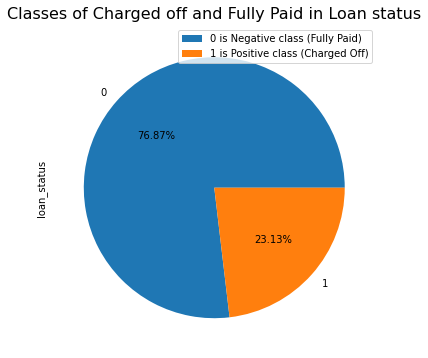

In [90]:
## Observe the imbalance data
df_xgb.loan_status.value_counts().plot.pie(autopct='%.2f%%')
plt.title('Classes of Charged off and Fully Paid in Loan status', fontsize=16)
plt.legend(labels=['0 is Negative class (Fully Paid)', '1 is Positive class (Charged Off)']) 

* It can be observed that Charged off is minority class (23.13%) compared to Fully Paid (76.87%). It means highly imbalanced data. In theory, any algorithm of machine learning will work best for balanced data with the ratio of positive class and negative class is equal to 1. This problem will be addressed in the next part.
* We use the split method of stratification to maintain the same percentage of borrowers in both training and test set, to make sure that both sets present the nature of data in reality (the likelihood of observing a Charged Off is less than Fully Paid).

In [91]:
# shuffling data and split it in a stratified fashion  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, train_size=0.7, random_state=42, stratify=y)

Splitting into training and test dataset help to evaluate the model and prevent the problem of overfitting. The chosen proportion of test set and train set here is 30%-70%.

In [92]:
# check if the stratified sampling method works by calculating the percentage of the Charged Off class
print('Percentage of Charged Off label in y_train: ', round(sum(y_train)/len(y_train)*100, 2), '%')

Percentage of Charged Off label in y_train:  23.13 %


The same percentage is received compared to the result in the pie chart. No problem found here when splitting into sets

In [93]:
# Size of data samples
print('Independent training size (x_train):', x_train.shape)
print('Dependent training size (y_train):', y_train.shape)
print('Independent testing size (x_test):', x_test.shape)
print('Dependent testing size (y_train):', y_test.shape)

Independent training size (x_train): (136610, 157)
Dependent training size (y_train): (136610,)
Independent testing size (x_test): (58548, 157)
Dependent testing size (y_train): (58548,)


* Both training sets have 136610 rows, x_train has 157 columns and y_train has 1 columns only.
* Both test sets have 58548 rows, x_test has 157 columns and y_test has 1 columns only.

# XGBOOST MODEL DEVELOPMENT

For imbalanced data, we set a base line score with Random Rate guessing strategy. There is no backed up theory for this, I use it as a rule of thumb. 

Odds of Guessing Minority Correct + Odds of Guessing Majority Correct = Baseline score $= 0.25^2 + 0.75^2 = 0.645$

We will try to train a model with important scores above 64.5%.

Source: 'Choosing a Baseline Accuracy for a Classification Model'.Towards Data Science. Aaron Lee. https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f

## Initial model

##### Initial XGBoost model 

In [94]:
%%time
# XGBoost model with default setting
xgb_1st = xgb.XGBClassifier(objective='binary:logistic', # the loss function used
                            use_label_encoder=False, # to remove a warning about future release
                            random_state=42) # without fixed number of random_state, each time running model will generate a different result 

xgb_1st.fit(x_train, y_train, 
              verbose=1, # show messages while training 
              early_stopping_rounds=20, 
              eval_metric='aucpr',  
              eval_set=[(x_train, y_train), (x_test, y_test)])

[0]	validation_0-aucpr:0.40640	validation_1-aucpr:0.39569
[1]	validation_0-aucpr:0.42144	validation_1-aucpr:0.40899
[2]	validation_0-aucpr:0.42733	validation_1-aucpr:0.41395
[3]	validation_0-aucpr:0.43516	validation_1-aucpr:0.41915
[4]	validation_0-aucpr:0.43845	validation_1-aucpr:0.42119
[5]	validation_0-aucpr:0.44183	validation_1-aucpr:0.42293
[6]	validation_0-aucpr:0.44545	validation_1-aucpr:0.42424
[7]	validation_0-aucpr:0.44928	validation_1-aucpr:0.42586
[8]	validation_0-aucpr:0.45346	validation_1-aucpr:0.42732
[9]	validation_0-aucpr:0.45765	validation_1-aucpr:0.42894
[10]	validation_0-aucpr:0.46204	validation_1-aucpr:0.42971
[11]	validation_0-aucpr:0.46625	validation_1-aucpr:0.43158
[12]	validation_0-aucpr:0.46994	validation_1-aucpr:0.43213
[13]	validation_0-aucpr:0.47386	validation_1-aucpr:0.43224
[14]	validation_0-aucpr:0.47571	validation_1-aucpr:0.43253
[15]	validation_0-aucpr:0.47830	validation_1-aucpr:0.43307
[16]	validation_0-aucpr:0.48178	validation_1-aucpr:0.43380
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Explain the settings in the model: 

* objective='binary:logistic' because we are solving the problem of binary classification, the model will generate the probability of the prediction, then use the default threshold of 0.5 to convert them into 1 or 0 class (Charged Off or Fully Paid).

* early_stopping_rounds=20: choose a common value at first to run the model. After 20 rounds if the aucpr score does not improved, the model will stopped.

* eval_metric='aucpr': 'aucpr' means the area under the precision-recall curve. Normally the common evaluation metrics for balanced data is 'error', but we focus on the class of 'Charged Off' more than 'Fully Paid' in an imbalanced data, so 'aucpr' should be chosen. (We are aiming to improve recall score, explained in the report)

* eval_set=[(x_train, y_train), (x_test, y_test)]: to generate the data for performance learning curves drawn later to compare how good the model performs on training and test set. 

* Documentation for XGBoost package: https://xgboost.readthedocs.io/en/stable/parameter.html

##### Evaluation

* In this part, the Accuracy score, Precision_score, Recall score will be checked not only on the overall level but also for each class of positive (Charged Off) and negative (Fully Paid). 

* The visualization of the confusion matrix serves the purpose that we can see directly how many values fall into categories of true positive, true negative, false positive, and false negative, which are closely connected to the calculation of the mentioned scores.

* The learning curves plot helps to check or diagnose the problem of the training model (such as underfiting, overfiting in training/test set...) 

In [95]:
# write a function helping to generate evaluation scores and confusion matrices at the same time
def evaluate_model(model_name, data_x, data_y):
    
    # prediction on training/test set
    y_prediction = model_name.predict(data_x)
    print('\n') # insert a break line
    
    # print out the report of precision, recall, accuracy and f1 scores
    print('1) CLASSIFICATION REPORT:') 
    print(classification_report(data_y, y_prediction))
    print('\n')
    
    # print out confusion matrix coresponding to the data set
    print('2) CONFUSION MATRIX')
    plot_confusion_matrix(model_name, data_x, data_y, display_labels=(['Fully Paid','Charged Off']))



1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88    105014
           1       0.69      0.21      0.32     31596

    accuracy                           0.80    136610
   macro avg       0.75      0.59      0.60    136610
weighted avg       0.78      0.80      0.75    136610



2) CONFUSION MATRIX


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


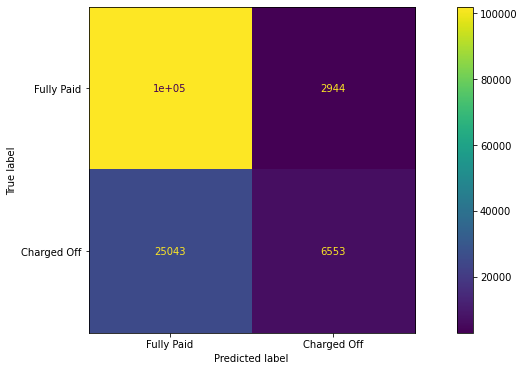

In [96]:
# Evaluation on the training set
evaluate_model(xgb_1st, x_train, y_train)



1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87     45006
           1       0.57      0.16      0.25     13542

    accuracy                           0.78     58548
   macro avg       0.68      0.56      0.56     58548
weighted avg       0.74      0.78      0.73     58548



2) CONFUSION MATRIX


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


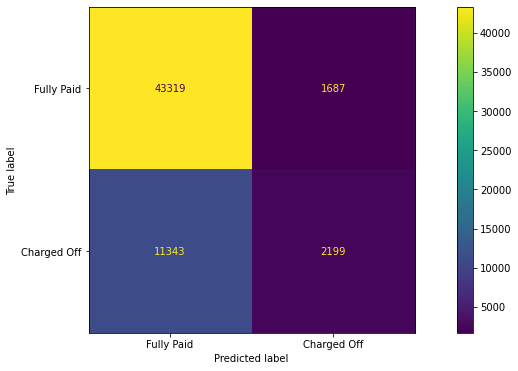

In [97]:
# Evaluation on the test set
evaluate_model(xgb_1st, x_test, y_test)

* The overall accuracy of the model on training and test set is almost the same (80% or 78%), and it seems to be good, but with a closer look on each positive and negative class, it is clearly that high accuracy score due to the fact that 77% of the data points belongs to the positive class. Meanwhile, the negative class (Charged Off) is what we focus, which have precision of 0.57 and recall 0.16, which are low and imply really bad prediction for true negative. With default settings the model tends to predict the result of Fully Paid because it happens more frequently.

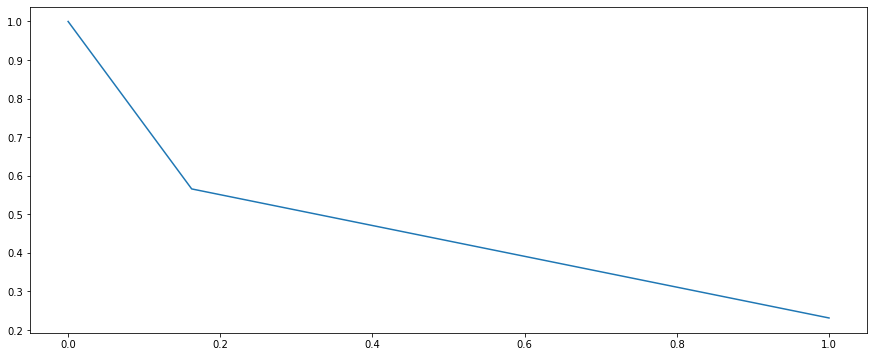

In [98]:
# Precision-Recall Curve
y_pred_1st = xgb_1st.predict(x_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred_1st)
plt.plot(recall, precision)

If the curve moves the top right of the graph, the better the performance of the model. This Precision-Recall curve suggests that the initial model is bad on predicting for True Positive class.

In [99]:
# define a learning curves function
def learn_curves(fitted_model):
    
    # retrieve performance metrics
    results = fitted_model.evals_result()

    # plot learning curves
    plt.plot(results['validation_0']['aucpr'], label='Learning curve on training set')
    plt.plot(results['validation_1']['aucpr'], label='Learning curve on test set')

    # show the legends and plot
    plt.legend()

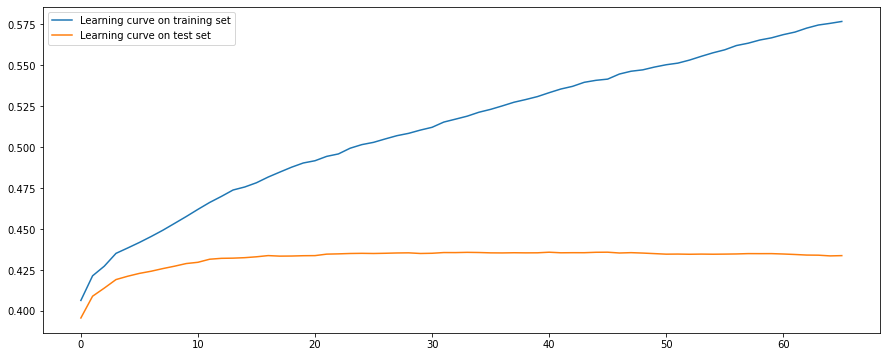

In [100]:
# Learning curve of the initial model
learn_curves(xgb_1st)

* The learning curves visualize *aucpr* scores while training. 
* It can be seen from the graph that from the 10th iteration the learning curve on test set is much lower compared to the learning curve of training set, and even does not improve while running. It means this default setting model performs better on the training set but poorly on the test set.

Conclusion:

* The first model is heavily affected by the imbalanced dataset without using tuning hyperarameters.
* Even the overall accuracy is 78%% but in fact the the class of Charged off is extremely poorly predicted. 
* The initial model does not perform well on both training and test set, and also shows the problem of imbalanced data and overfitting when checking the learning curves.

## Tuning hyperparameters

* To solve the problem of:
        * imbalanced data: tuning scale_pos_weight and max_delta_step
        * overfiting: 
            * The first way is to directly control model complexity: max_depth, min_child_weight and gamma.
            * The second way is to add randomness to make training robust to noise: subsample and colsample_bytree, reducing eta (learning rate) with increasing num_round (or n_estimators in sklearn)
    (Source: Notes on Parameter Tuning. https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)

* For tuning hypeparameters, the main expectation of evaluation is trying to obtains higher scores on the same folds. First a dictionary of hyperparameters are listed, then data is stratifiedly split and choose a suitable method for tuning in term of time and accuracy.

In [101]:
# Step 1: Create parameter spaces
params = {'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
         'n_estimators': [100, 200, 400, 800, 1000],
         'scale_pos_weight': [1, 2, 3, 4],
         'max_depth': [3,4, 5,6, 7,8, 9,10],
         'gamma': [0, 0.01, 0.1, 0.5, 1, 2],
         'min_child_weight': [1, 2, 3, 4, 5,6,7,8,9,10],
         'colsample_bytree': [0.8, 0.9, 1],
         }

* The suggested values of the hyperparameter:
    * scale_pos_weight is set around value of 3 because follow the fomular of *scale_pos_weight = sum(negative instances)/sum(positive instances) = 3.2* (calculated previously in part named Handling Loan status). 
    
    (Source: XGBoost Parameters. https://xgboost.readthedocs.io/en/stable/parameter.html)
    
    * the rest of values in the list based on 'Tune an XGBoost Model' (https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html)

In [102]:
# Choose a method: Stratified K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [103]:
# Decide the score metrics to evaluate your model: based on recall score

* Choosing the appropriate approach for tuning, there are two popular methods: 
        * GridSearchCV (considers all possible combinations of hyperparameters)
        * RandomizedSearchCV (only few samples of parameter combinations are selected with resampling technique, not an exhausting searching like GridSearchCV). RandomizedSearchCV outperforms GridSearchCV in terms of running time for a big dataset. Considering time and computational capacity in this project, RandomizedSearchCV is prefered.

#### Approach 1

RandomizedSearchCV is executed with different evaluation scores: recall, accuracy and roc_auc.

In [ ]:
%%time
# Run RandomizedSearchCV to tune the hyperparameter 
random = RandomizedSearchCV(xgb_1st, 
                            param_distributions=params, 
                            cv=kfold, 
                            n_iter=5, 
                            scoring='recall',
                            n_jobs=-1)

random.fit(x_train, y_train)

print('Best hyperparameter:', random.best_params_)
print('Best score:', random.best_score_)

In [ ]:
# Run RandomizedSearchCV to tune the hyperparameter
random = RandomizedSearchCV(xgb_1st, 
                            param_distributions=params, 
                            cv=kfold, 
                            n_iter=5, 
                            scoring='accuracy',
                            n_jobs=-1)

random.fit(x_train, y_train)

print('Best hyperparameter:', random.best_params_)
print('Best score:', random.best_score_)

In [ ]:
# Run RandomizedSearchCV to tune the hyper-parameter
random = RandomizedSearchCV(xgb_1st, 
                            param_distributions=params, 
                            cv=kfold, 
                            n_iter=5, 
                            scoring='roc_auc',
                            n_jobs=-1)

random.fit(x_train, y_train)

print('Best hyperparameter:', random.best_params_)
print('Best score:', random.best_score_)

* Each time re-run RandomizedSearchCV will generate a different result. By far, the model have been fitted with many combinations of hyperparameters as below:

    * {'scale_pos_weight': 4, 'n_estimators': 200, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.01, 'colsample_bytree': 1}
    
    * {'scale_pos_weight': 1, 'n_estimators': 800, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.9}
    
    * {'scale_pos_weight': 4, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9}
    
    * { 'scale_pos_weight': 4, 'n_estimators': 800, 'min_child_weight': 1,'max_depth': 5, 'learning_rate': 0.01, 'gamma': 2, 'colsample_bytree': 1}
    
    *...
    
* A new model is then evaluated as presented in the next part.

#### Approach 2

The most efficient way to tune hyperparameters is using below GridSearchCV, but it will take a huge amount of time ( days) with 19440 candidates, totalling 97200 fits, so we do not execute this.

## Optimized model

* early_stopping_rounds=10: reduce it to prevent overfitting based on the learning curves of initial model 
* The model below presented below is just one of the candidates we can consider for the final model chosen for the Dash app. All hyperparameter combinations found should be fitted and evaluated with the same steps. 

##### Fit the model

In [104]:
%%time
# run the model with added hyperparameters
xgb_model_op = xgb.XGBClassifier(objective='binary:logistic',
                                  learning_rate=0.01, 
                                 scale_pos_weight=4,
                                 n_estimators=800,
                                 max_depth=5,
                                 min_child_weight=1,
                                 gamma=2, 
                                 colsample_bytree=1,
                                 use_label_encoder=False,
                                 random_state=42)

xgb_model_op.fit(x_train, y_train, 
                 verbose=1, 
                 early_stopping_rounds=10, 
                 eval_metric='aucpr', 
                 eval_set=[(x_train, y_train), (x_test, y_test)])

[0]	validation_0-aucpr:0.39210	validation_1-aucpr:0.39051
[1]	validation_0-aucpr:0.39957	validation_1-aucpr:0.39650
[2]	validation_0-aucpr:0.40065	validation_1-aucpr:0.39762
[3]	validation_0-aucpr:0.40104	validation_1-aucpr:0.39713
[4]	validation_0-aucpr:0.40074	validation_1-aucpr:0.39707
[5]	validation_0-aucpr:0.40334	validation_1-aucpr:0.40026
[6]	validation_0-aucpr:0.40387	validation_1-aucpr:0.40039
[7]	validation_0-aucpr:0.40418	validation_1-aucpr:0.40123
[8]	validation_0-aucpr:0.40454	validation_1-aucpr:0.40117
[9]	validation_0-aucpr:0.40440	validation_1-aucpr:0.40131
[10]	validation_0-aucpr:0.40497	validation_1-aucpr:0.40166
[11]	validation_0-aucpr:0.40503	validation_1-aucpr:0.40161
[12]	validation_0-aucpr:0.40695	validation_1-aucpr:0.40331
[13]	validation_0-aucpr:0.40689	validation_1-aucpr:0.40309
[14]	validation_0-aucpr:0.40688	validation_1-aucpr:0.40315
[15]	validation_0-aucpr:0.40698	validation_1-aucpr:0.40309
[16]	validation_0-aucpr:0.40801	validation_1-aucpr:0.40380
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=2, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=800, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

##### Evaluation



1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.56      0.69     45006
           1       0.34      0.76      0.47     13542

    accuracy                           0.61     58548
   macro avg       0.62      0.66      0.58     58548
weighted avg       0.76      0.61      0.64     58548



2) CONFUSION MATRIX


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


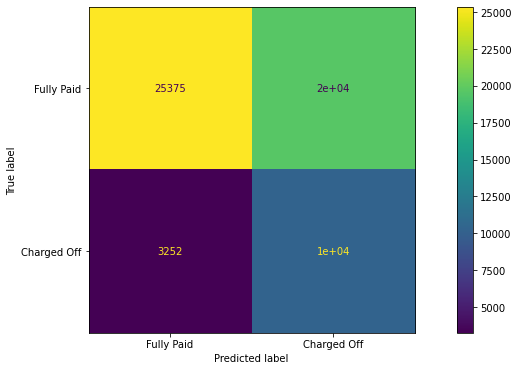

In [105]:
# Evaluation on the test set
evaluate_model(xgb_model_op, x_test, y_test)

* It can be seen that while overall accuracy is reduced to 61%, which is the trade off between bias and variance. If we add more regularization in the model, the over accuracy has to be sacrificed (high variance)
* The recall score of positive class (Charged Off) is significant increase to 76%. 

In [106]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
y_pred_prob_op = xgb_model_op.predict_proba(x_test)[:,1] # filter results for the positive class only
print('Optimized model:', roc_auc_score(y_test, y_pred_prob_op))

# Compare to the initial model
y_pred_prob_1st = xgb_1st.predict_proba(x_test)[:,1] 
print('Initial model:', roc_auc_score(y_test, y_pred_prob_1st))

Optimized model: 0.7282563140484271
Initial model: 0.7254873417721104


The AUC ROC score of the optimized model is slightly higher than that of the initial model, but both are around 72%. It suggests that the the ability of distinguishing between classes almost the same. 

In [107]:
# compare AUCPR (Area under the Precision-Recall curve) of the initial model and the new model
print('AUC PR of the initial model:', average_precision_score(y_test, y_pred_1st))
y_pred_op = xgb_model_op.predict(x_test)
print('AUC PR of the model after tuning:', average_precision_score(y_test, y_pred_op))

AUC PR of the initial model: 0.2856277519245852
AUC PR of the model after tuning: 0.3168636793385814


AUC PR of the new model is higher than that of initial model, meaning that the number of true positive class predicted with the new hyperparamter increases, which is what we expected. 

##### Feature importance and learning curves

* XGBoost has a build in operation to select the best features in classification process. However, it is needed to know that standard model with default setting ranks the features differently compared to a model with tunned parameters.
* This is the reason why we check the feature importances with the more efficient model (tunned parameter)
* A subset of features is chosen with a threshold, then we decide which features should be kept.

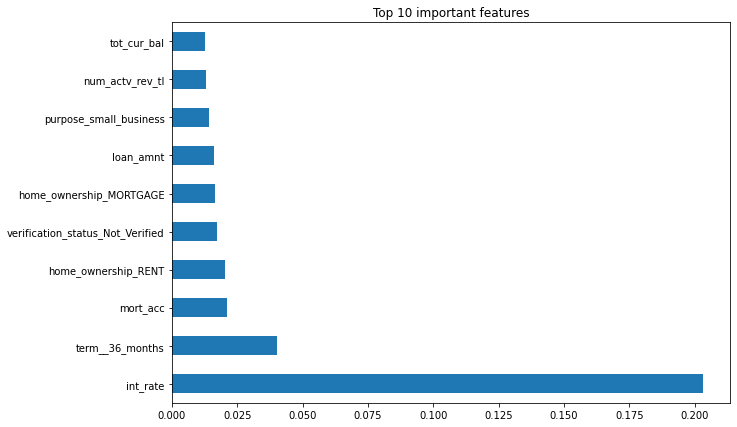

In [108]:
# Xgboost Built-in Feature Importance
feat_importances = pd.Series(xgb_model_op.feature_importances_, index=x.columns)

# plot them in a bar chart
feat_importances.nlargest(10).plot(kind='barh', figsize=(10,7))
plt.title("Top 10 important features")

# importance type
xgb_model_op.importance_type

* The graph above is based on Information Gain.
* The graph shows that interest rate and loan term of 36 months are the most influent factor in predicting.

In [109]:
# create a dictionary from unpacked feature_importance
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, xgb_model_op.feature_importances_):
    feats[feature] = importance #add the name/value pair
    feats.update(feats)
    
# turn the dictionary into dataframe with suitable column names
df_feat_im = pd.DataFrame.from_dict(feats, orient='index')
df_feat_im.reset_index(inplace=True)
df_feat_im.rename(columns={"index": "feature", 0:'score'}, inplace=True)

# sort the table values from higest to lowest order
df_feat_im.sort_values('score', ascending=False)

feature     score
2                               int_rate  0.203264
155                      term__36_months  0.040090
27                              mort_acc  0.021262
108                  home_ownership_RENT  0.020526
102     verification_status_Not_Verified  0.017178
106              home_ownership_MORTGAGE  0.016653
1                              loan_amnt  0.016268
99                purpose_small_business  0.014165
30                       num_actv_rev_tl  0.012888
9                            tot_cur_bal  0.012852
74                         addr_state_OR  0.011224
84                         addr_state_WA  0.011213
90            purpose_debt_consolidation  0.010887
20                          inq_last_12m  0.010757
43                         addr_state_CO  0.010648
35                          FICO_average  0.010317
71                         addr_state_NY  0.010198
32                             num_il_tl  0.009874
17                            max_bal_bc  0.009598
4                                    dti  0.009358
16                           open_rv_12m  0.008772
39                         addr_state_AL  0.008701
104         verification_status_Verified  0.008503
24                  mo_sin_old_rev_tl_op  0.008279
47                         addr_state_FL  0.008152
96                        purpose_moving  0.008023
10                           open_acc_6m  0.007922
42                         addr_state_CA  0.007843
26                        mo_sin_rcnt_tl  0.007681
36           application_type_Individual  0.007582
28                  mths_since_recent_bc  0.007513
34                        total_bc_limit  0.007371
119               emp_length_less_1_year  0.007086
89                   purpose_credit_card  0.007083
75                         addr_state_PA  0.006971
95                       purpose_medical  0.006928
93                         purpose_house  0.006906
86                         addr_state_WV  0.006902
57                         addr_state_MD  0.006773
81                         addr_state_UT  0.006562
97                         purpose_other  0.006509
3                             annual_inc  0.006443
73                         addr_state_OK  0.006437
55                         addr_state_LA  0.006396
83                         addr_state_VT  0.006302
22                               bc_util  0.006235
92              purpose_home_improvement  0.006224
8                              revol_bal  0.006111
110             emp_length_10_more_years  0.006038
58                         addr_state_ME  0.006027
13                    mths_since_rcnt_il  0.006015
54                         addr_state_KY  0.005962
122                         sub_grade_A3  0.005940
40                         addr_state_AR  0.005926
50                         addr_state_ID  0.005835
19                           total_cu_tl  0.005756
140                         sub_grade_E1  0.005726
25                 mo_sin_rcnt_rev_tl_op  0.005675
116                   emp_length_7_years  0.005657
65                         addr_state_ND  0.005648
11                           open_act_il  0.005640
109                    emp_length_1_year  0.005574
88                           purpose_car  0.005476
94                purpose_major_purchase  0.005407
70                         addr_state_NV  0.005368
0                                  index  0.005341
21                  acc_open_past_24mths  0.005314
77                         addr_state_SC  0.005253
82                         addr_state_VA  0.005134
7                                pub_rec  0.005100
41                         addr_state_AZ  0.005032
59                         addr_state_MI  0.004943
29                 num_accts_ever_120_pd  0.004922
62                         addr_state_MS  0.004895
46                         addr_state_DE  0.004800
85                         addr_state_WI  0.004784
126                         sub_grade_B2  0.004698
5                            delinq_2yrs  0.004678
18  

In [110]:
# the thresholds are chosen based on the table
for thresh in [0.005, 0.01]:
    # select features using the thresholds
    selection = SelectFromModel(xgb_model_op, threshold=thresh, prefit=True) 
    select_x_train = selection.transform(x_train)
    # train the model
    selection_model = xgb.XGBClassifier(objective='binary:logistic',
                                          learning_rate=0.01, 
                                         scale_pos_weight=4,
                                         n_estimators=800,
                                         max_depth=5,
                                         min_child_weight=1,
                                         gamma=2, 
                                         colsample_bytree=1,
                                        use_label_encoder=False, random_state=42)
    selection_model.fit(select_x_train, y_train, eval_metric='aucpr')
    # evaluate the model on test set
    select_x_test = selection.transform(x_test)
    predictions = selection_model.predict(select_x_test)
    print('Threshold:', thresh, '- Number of features:', select_x_train.shape[1], 
          '- Recall score:', recall_score(y_test, predictions)*100)

X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names


Threshold: 0.005 - Number of features: 71 - Recall score: 75.99320632107516


X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names


Threshold: 0.01 - Number of features: 17 - Recall score: 76.14827942696795


* Two thresholds are chosen based on the feature importance table, which are 0.005 and 0.01. 
* At threshold of 0.005, there are 71 features left and the recall score is 75.99%, and at the level of 0.01, the recall score is reduced slightly at 76.14%.
* Conclusion: No further features should be dropped. The model has all the features it needs.

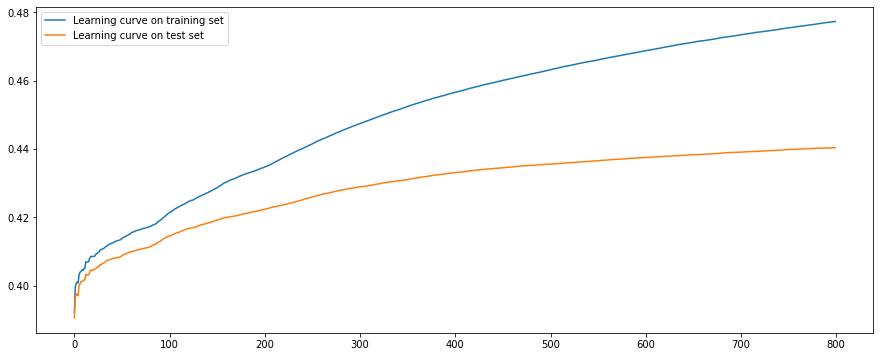

In [111]:
#plot learning curves for the optimized model
learn_curves(xgb_model_op)

The learning curves are closer to each other now showing the overfitting problem is improved

Conclusion:
* No need to reduce the number of predictors.

* There are improvements in evaluation metrics in general, but we want a model with acceptable overall accuracy besides the high recall score for the positive class (Charged Off).

* This model still shows the overfitting, so we will plug other combinations from the tunning hyperparameters process and continue to evaluate other models.

* After several times of trials and errors, the final combination is presented in the next part.

## Final model

Pushing the recall score too high is not a good direction, so we will try to make the overall accuracy higher while increasing recall score to an acceptable level. The final combination of hyperparameters is chosen below.

##### Fit the model

In [112]:
%%time
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              learning_rate=0.05,
                              scale_pos_weight=3,
                              n_estimators=200,
                              max_depth=5,
                              min_child_weight=1,
                              gamma=0.5,
                              colsample_bytree=1,
                              subsample=1,
                              use_label_encoder=False,
                              random_state=42)

xgb_model.fit(x_train, y_train, 
              verbose=0, 
              early_stopping_rounds=10, 
              eval_metric='aucpr', 
              eval_set=[(x_train, y_train), (x_test, y_test)])

CPU times: user 6min 17s, sys: 893 ms, total: 6min 18s
Wall time: 1min 38s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

##### Evaluation



1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.86      0.69      0.77     45006
           1       0.38      0.64      0.48     13542

    accuracy                           0.68     58548
   macro avg       0.62      0.66      0.62     58548
weighted avg       0.75      0.68      0.70     58548



2) CONFUSION MATRIX


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


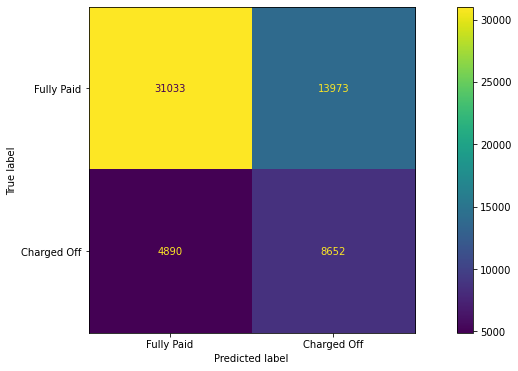

In [113]:
# Evaluation on the test set
evaluate_model(xgb_model, x_test, y_test)

In [114]:
# AUC ROC 
# note that here the prediction results in probability is used
y_pred_prob = xgb_model.predict_proba(x_test)[:,1]
roc_auc_score(y_test, y_pred_prob).round(2)

0.73

Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.


Text(0.5, 1.0, 'ROC curve')

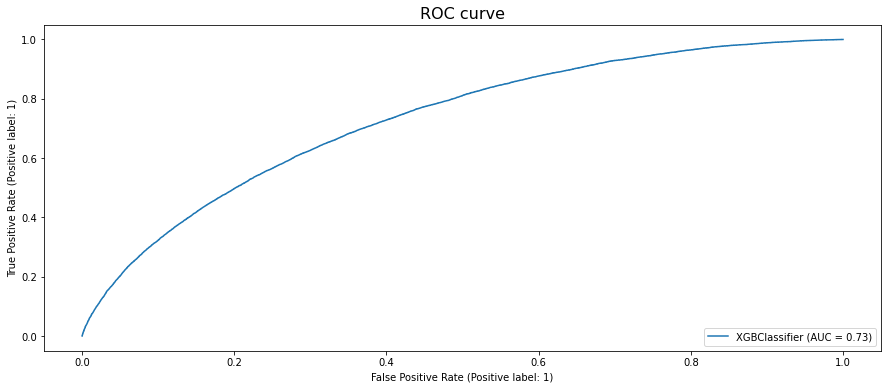

In [115]:
# ROC AUC curve
plot_roc_curve(xgb_model, x_test, y_test)
plt.title('ROC curve', fontsize=16)

The AUC ROC score is slightly higher than that of other model.

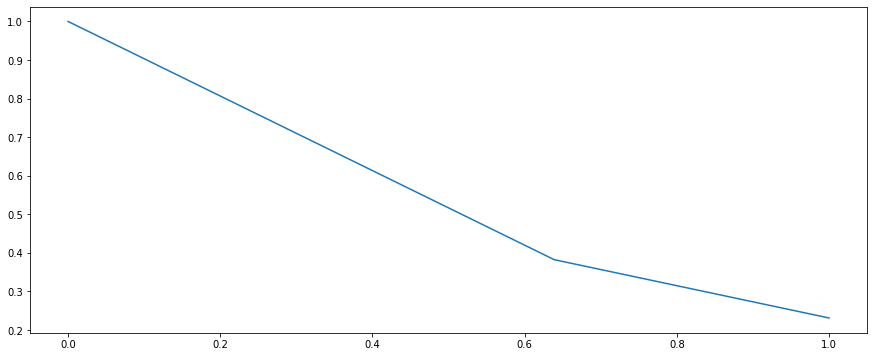

In [116]:
# compute the prediction on test result 
y_pred_xgb = xgb_model.predict(x_test)

# unpack the results of precision_recall_curve function
precision, recall, _ = precision_recall_curve(y_test, y_pred_xgb)
plt.plot(recall, precision)

In [117]:
# compute the AUC PR score
average_precision_score(y_test, xgb_model.predict(x_test))

0.3278426785655767

The AUC PR score of the final model is higest one found compared to other model.

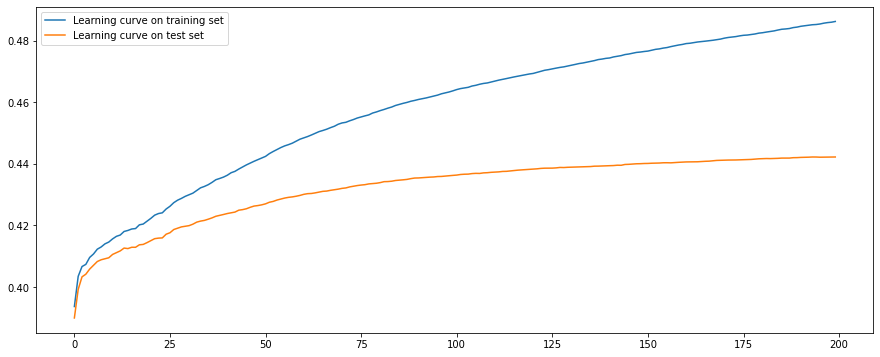

In [118]:
# Learning curves
learn_curves(xgb_model)

Two learning curves show the improvement but not so significant.

##### Change threshold

Note that the final way to improve the performance of the model is changing the threshold. We try to find an optimal point that maximize the True positive rate and low false positive rate.

In [119]:
# from numpy import argmax
# unstack elements of roc_curve()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# find the best threshold
optimal = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal]
optimal_threshold

0.47757018

In [120]:
# visualize the threshold on the roc curve
plt.scatter(fpr, tpr, s=5)
plt.scatter(fpr[optimal], tpr[optimal], s=80, marker=',', color='orange', label='Best threshold')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [121]:
# change the threahold of the model
y_pred_change = xgb_model.predict_proba(x_test)[:, 1] > thresholds[optimal]
print(classification_report(y_test, y_pred_change))

              precision    recall  f1-score   support

           0       0.87      0.65      0.75     45006
           1       0.37      0.68      0.48     13542

    accuracy                           0.66     58548
   macro avg       0.62      0.67      0.61     58548
weighted avg       0.76      0.66      0.68     58548



In [122]:
# confustion matrix after changing the threshold
confusion_matrix(y_test, y_pred_change)

array([[29298, 15708],
       [ 4312,  9230]])

We can see that the recall score for positive class improved to 0.68, but the trade off is that the overall accuracy is reduced to 0.66, so changing threshold is not recommended here.

## Cross validation

In [123]:
%%time
scores = cross_val_score(xgb_model, x, y, cv=kfold)
print('Accuracy:', np.round(scores, 3))
print('Accuracy mean: %0.3f' % (scores.mean()))

[10:31:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:33:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:35:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:36:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

* We use the same StratifiedKFold for cross-validation. This is the final check if the model can perform consistently on the subsets of data.
* From the result we can see for different folds the XGBoost model generates a consistent accuracy score of around 67.9%, so we accept this model and use it for the Dash app.

# INTERPRET XGBOOST MODEL RESULS

* After evaluating a model, there are some questions related to the explainability of the mode such as how each feature affects the outcome and to what extent users can trust the model. If there is an explainability dashboard for the model, users can find a way to improve the accuracy and find the errors (debugging) when applying it in practice.

* There are some ways to provide explainability for the XGBoost model, which are built-in Feature Importance, Feature Permutation Importance, and SHAP (SHapley Additive exPlanations) on global and individual interpretability. SHAP has some advantages compared to the rest since SHAP can further show each features’ contributions to output with negative or positive direction.

## Global explanation

### Feature Permutation Importance

In [124]:
%%time
# compute permutation importance on test set
result_test = permutation_importance(xgb_model, x_test, y_test, 
                                     n_repeats=5, # randomly shuffled each feature 5 times
                                     random_state=42,  
                                     n_jobs=2)
sorted_idx = result_test.importances_mean.argsort()

CPU times: user 8.74 s, sys: 353 ms, total: 9.09 s
Wall time: 3min 18s


In [125]:
%%time
# compute permutation importance on train set
result_train = permutation_importance(xgb_model, x_train, y_train, n_repeats=5, random_state=42, n_jobs=2)
sorted_idx = result_train.importances_mean.argsort()

CPU times: user 9.79 s, sys: 280 ms, total: 10.1 s
Wall time: 6min 56s


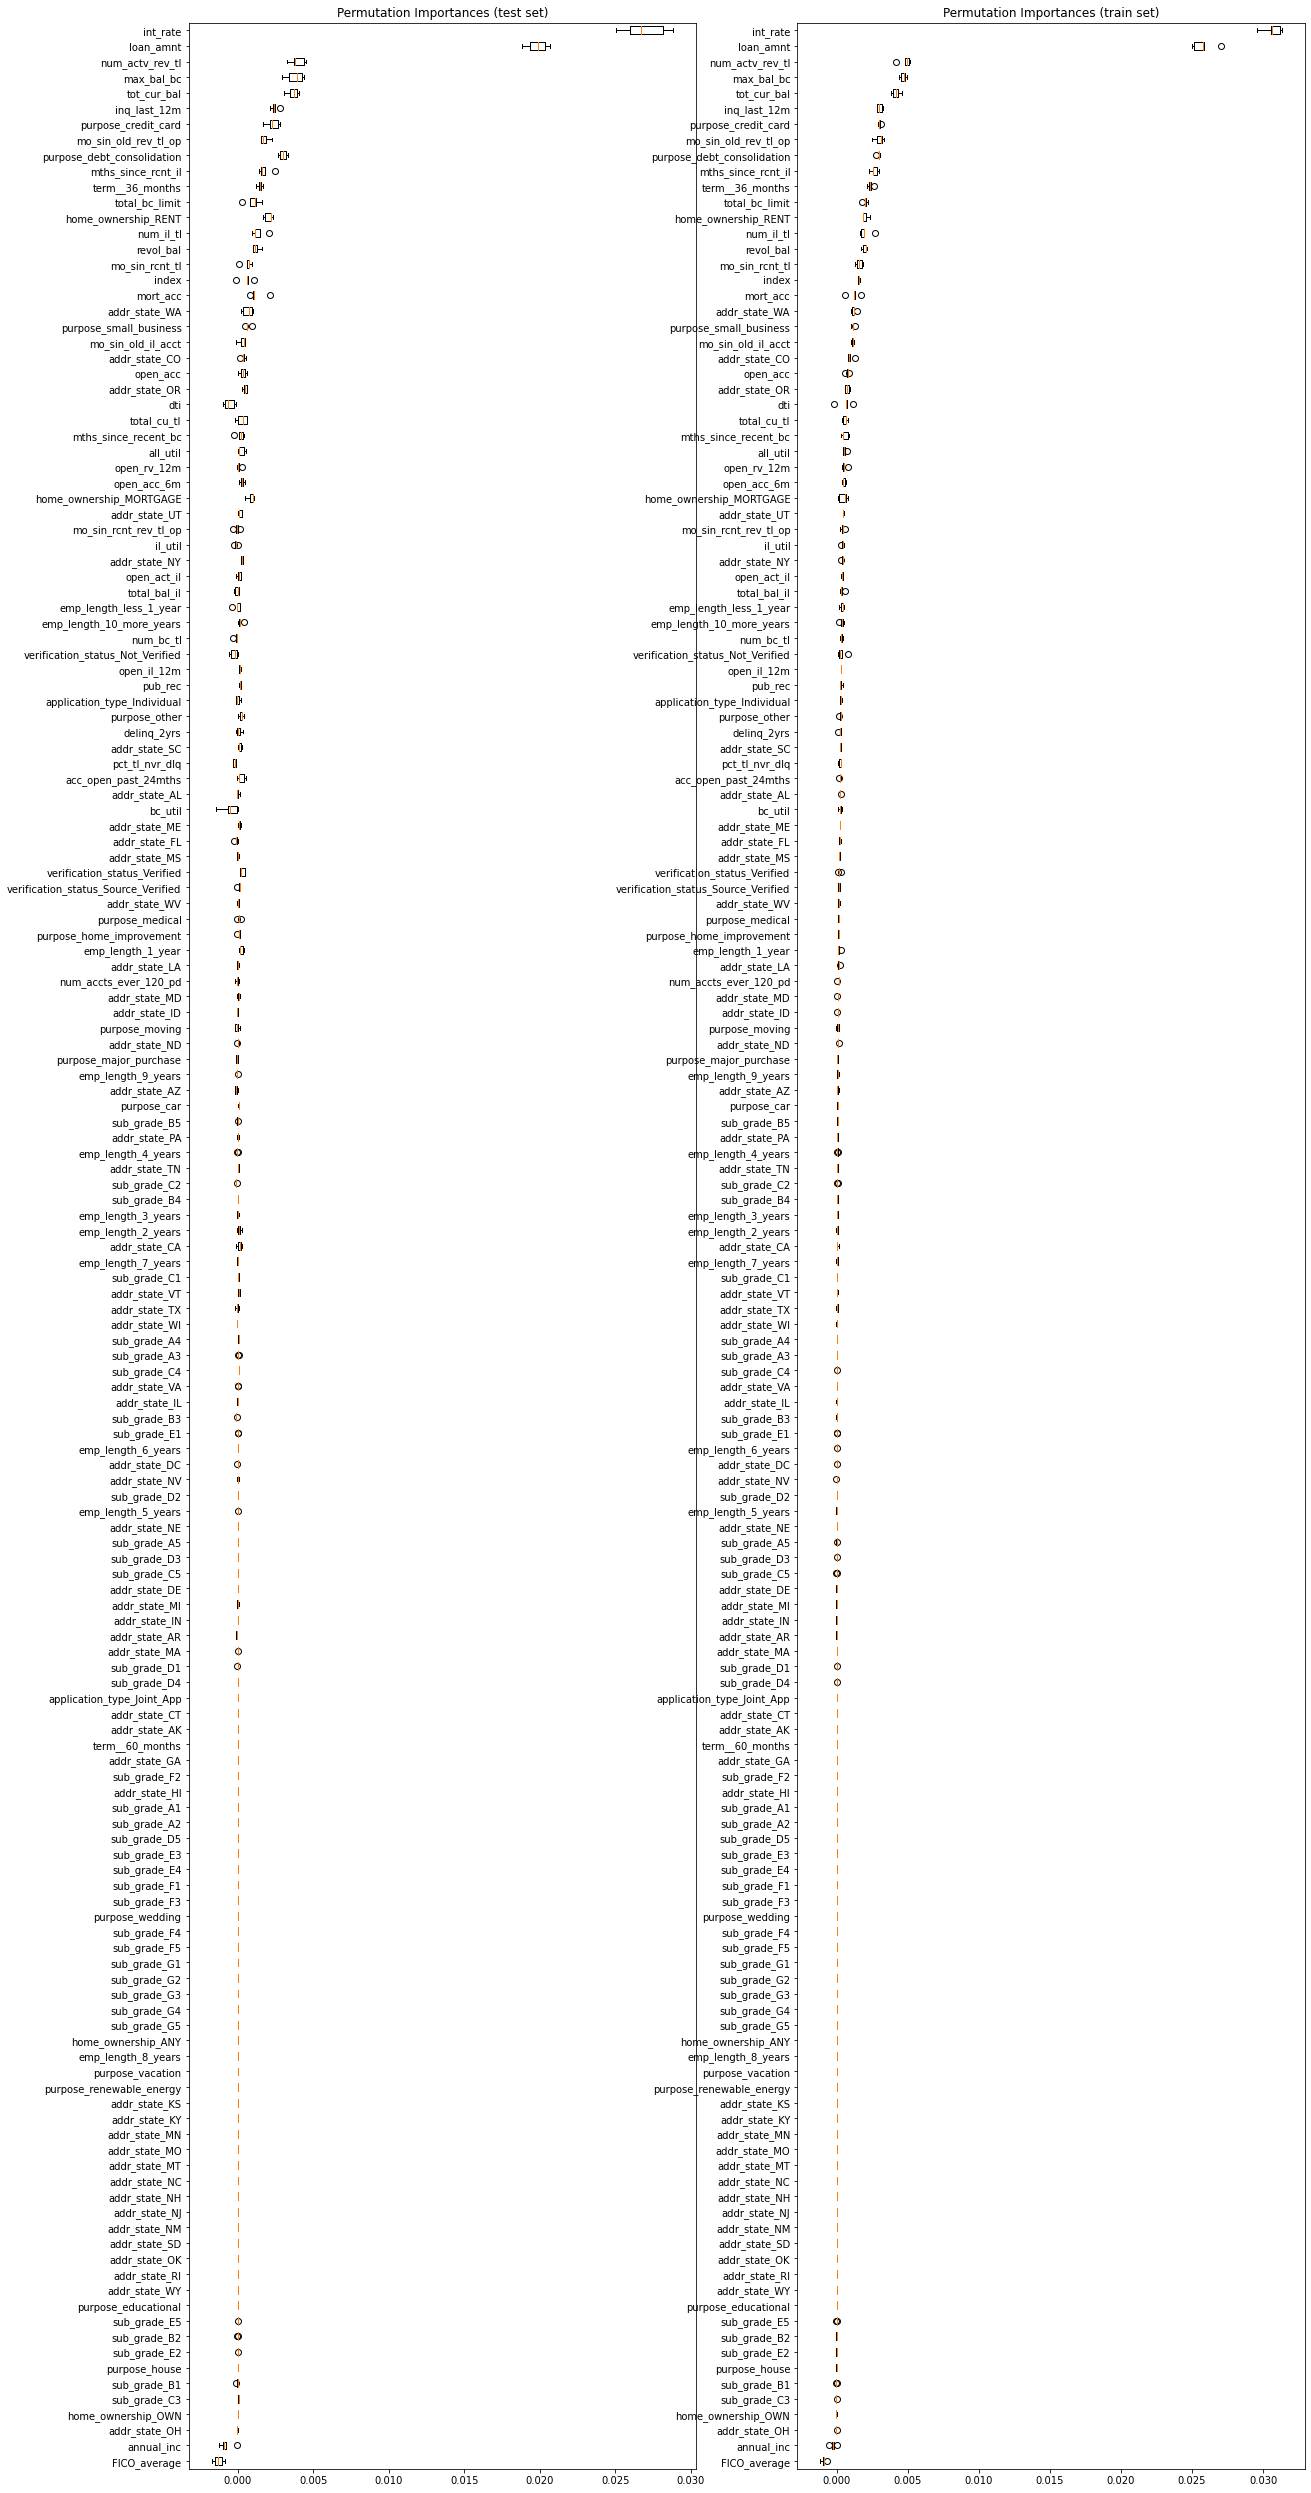

CPU times: user 7.23 s, sys: 722 ms, total: 7.95 s
Wall time: 7.58 s


In [126]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 45)) #, sharey=True

# test set
ax1.boxplot(result_test.importances[sorted_idx].T, vert=False, labels=x_test.columns[sorted_idx])
ax1.set_title("Permutation Importances (test set)")

# training set
ax2.boxplot(result_train.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax2.set_title("Permutation Importances (train set)")

plt.show()

* As can be seen from the graphs, the features have highest impact on the model performance is interest rate and loan amount. The rest has much little impact on the model.
* This boxlot will appear in the Dash app again, but simplize to a bar chart (use the mean figures only) to present a clearer ranks among features.

### Feature importance

Text(0.5, 1.0, 'Top 10 important features')

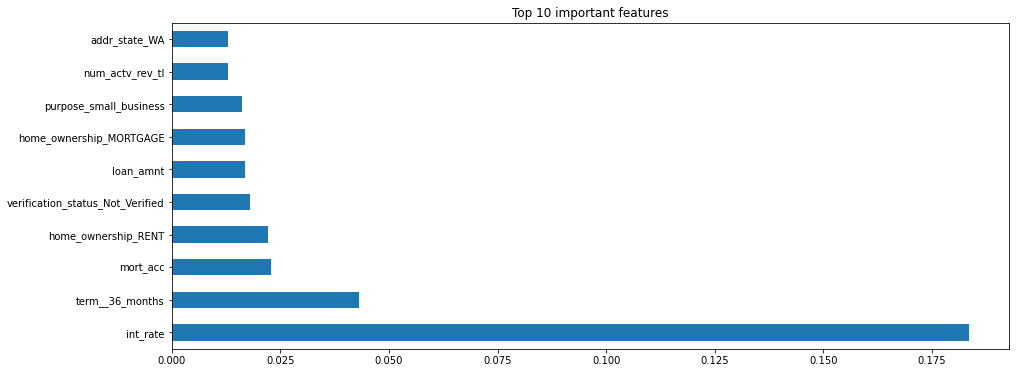

In [127]:
# using built-in function feature_importances_
feat_importances = pd.Series(xgb_model.feature_importances_, index=x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 important features")

* Note that there are many types of feature importance, here the importance calculated on Information Gain is used here. 'Gain' shows each feature's importance if it is used for splitting.

* Top 10 features with the highest gain score is presented in the graph, but the features which have the most significant scores are interest rate and the loan term of 36 months. Comparing this to Feature Permutation Importance plot, we can see the difference when the feature ranked 1st are the same (int_rate) but the second highest one now is changed.

### SHAP - Global interpretation

In [128]:
%%time
#  explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_model)
shap_values = explainer(x_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 5min 34s, sys: 429 ms, total: 5min 34s
Wall time: 1min 26s


In [129]:
%%time
shap_values = shap.Explainer(xgb_model).shap_values(x_train)

CPU times: user 5min 34s, sys: 431 ms, total: 5min 34s
Wall time: 1min 26s


##### Bar chart

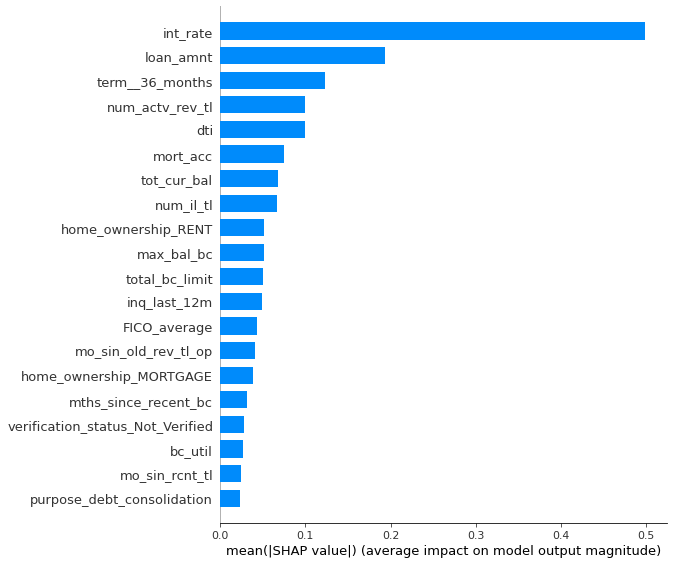

In [130]:
# Bar chart
shap.summary_plot(shap_values, x_train, plot_type="bar", show=False)
# save the plot image to the local folder for later useage in reports and Dash app 
plt.savefig('Shap_plot_01.png', bbox_inches='tight')

* A variable importance plot lists the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power.
* The calculation in this graph is based on SHAP values, which is different from the built-in function of XGBoost model. However, both graphs shows similar results of the highest influential features.

##### Density scatter plot of SHAP values

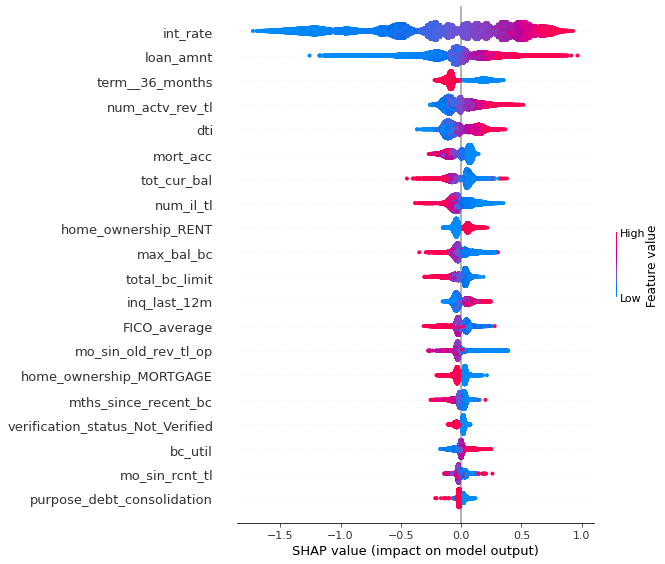

In [131]:
# a density scatter plot 
shap.summary_plot(shap_values, x_train, show=False)
# save the image
plt.savefig('Shap_plot_02.png', bbox_inches='tight')

* This SHAP value plot can further show the positive and negative relationships of the predictors with the target variable. Features are ranked in descending order.

* Low interest rate (blue dots to the left) lower the probability of outcomes, meaning a higher chance of repay loans. High interest rate (red dots to the right) implies that it lowers the chance of repay loans.
* Low loan amount has a negative impact on prediction outcome, meaning increasing chance of successfully repayment. 
* The higher value of loan term of 36 months (implies 60 months) negatively impacts the output, meaning increasing a chance of repayment.
* The other features can be interpreted in the same logics, and it is evidenced form the graphs that the most significantly influent features again are interest rate and loan amount.   


### Local Interpretability - Individual SHAP Values

In [132]:
# load Javascript library for visualization in notebook
shap.initjs()
# shap TreeExplainer for the tree based model
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_train)

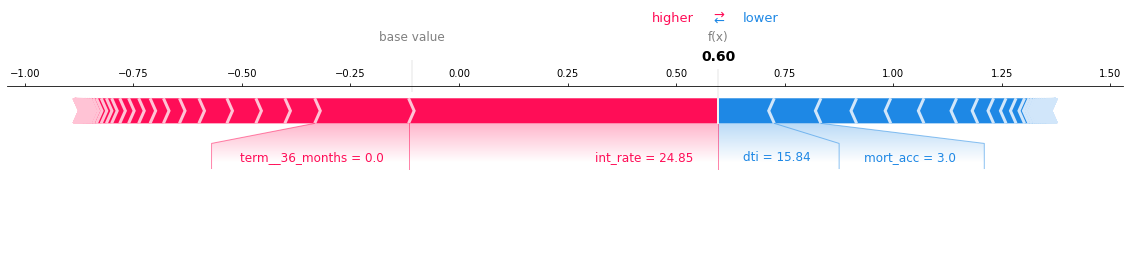

In [133]:
# plot and save the image for the report
def shap_indiv_plot(m):
    return shap.force_plot(explainer.expected_value, shap_values[m], x_train.iloc[[m]],  # filter the row only
                          show=False,matplotlib=True).savefig('Shap_plot_03.png', bbox_inches='tight')

# plot the Shap values for the 9th data point/borrower in the dataset, for example
shap_indiv_plot(9)

Interpretation of the graph:

* The output value: 0.6
* The base value is the value that would be predicted if we did not know any features to the current output.
(Source: Lundberg & Lee (2017).https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf, p.5)

* The interest rate is 24.85% and higher rate will push the output to the left, meaning a higher chance of being charged off. Additionally, the magnitude of the bar shows that the interest rate has the highest impact on the output.
* In contrast, the low (blue) value of mort_acc has a negative impact on the output probability prediction. The lower the mort_acc value, the higher chance of repayment.
* dti has almost the same magnitude of effect as mort_acc.

In [134]:
# SHAP Documentation and examples: 
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

### XGBoost tree

Note: The output in the leaves node (the leftmost level) is calculated from log loss function, so it needs transforming into probability before using the threshold to convert to class of Fully Paid of Charged Off.

In [135]:
# plot using the library of graphviz
# the tree is plotted form left to right 
xgb.plot_tree(xgb_model, rankdir='LR')

# get the current figure with matplotlib
fig = plt.gcf()
# change the size of image
fig.set_size_inches(150, 100)
# export the image into format of png for using in the Dash app
fig.savefig('xgb_tree.png', bbox_inches='tight')

# COMPARING TO LOGISTIC REGRESSION MODEL

This project using XGBoost model, but another algorithm here (Logistic Regression) is choosen to compare the difference betwwen performances.

##### Fit Logistic model

In [136]:
%%time
logis_model = LogisticRegression(solver='liblinear',
                                 max_iter=100,
                                 multi_class='ovr', # for binary classification problem
                                 class_weight = {0:0.2, 1:0.8}, # assigned weights for positie and negative class
                                 verbose=1,
                                random_state=42)

logis_model.fit(x_train, y_train)

[LibLinear]iter  1 act 3.763e+02 pre 3.732e+02 delta 1.332e-06 f 3.208e+04 |g| 9.889e+08 CG   2
cg reaches trust region boundary
iter  2 act 6.077e+01 pre 6.084e+01 delta 2.117e-06 f 3.170e+04 |g| 6.655e+07 CG   1
cg reaches trust region boundary
iter  3 act 1.043e+02 pre 1.034e+02 delta 3.087e-06 f 3.164e+04 |g| 3.102e+08 CG   3
cg reaches trust region boundary
iter  4 act 1.443e+02 pre 1.447e+02 delta 8.033e-06 f 3.154e+04 |g| 1.006e+08 CG   3
cg reaches trust region boundary
iter  5 act 2.736e+02 pre 2.715e+02 delta 2.270e-05 f 3.139e+04 |g| 5.900e+07 CG   3
cg reaches trust region boundary
iter  6 act 4.088e+02 pre 3.989e+02 delta 2.731e-05 f 3.112e+04 |g| 5.815e+07 CG   4
iter  7 act 5.540e+01 pre 5.474e+01 delta 2.731e-05 f 3.071e+04 |g| 2.077e+07 CG   7
iter  8 act 1.474e+00 pre 1.465e+00 delta 2.731e-05 f 3.066e+04 |g| 2.322e+06 CG   9
cg reaches trust region boundary
iter  9 act 3.050e+00 pre 3.061e+00 delta 3.907e-05 f 3.065e+04 |g| 2.010e+05 CG  10
cg reaches trust region bo

LogisticRegression(class_weight={0: 0.2, 1: 0.8}, multi_class='ovr',
                   random_state=42, solver='liblinear', verbose=1)

The model is run with the new class_weight assigned (0.2 for Fully Paid and 0.8 for Charged Off) to cope with the problem of imbalanced data, and the running time is pretty fast.

##### Evaluation 

In [137]:
evaluate_model(logis_model, x_test, y_test)



1) CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.57      0.69     45006
           1       0.34      0.73      0.46     13542

    accuracy                           0.61     58548
   macro avg       0.61      0.65      0.58     58548
weighted avg       0.75      0.61      0.64     58548



2) CONFUSION MATRIX


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


* The overall accuracy is 60% and the recall for positive class is 74%, which is lower than the XGBoost model. However, for the Logistic Regression, we do not have much option to tunning hyperparameters, unlike XGBoost. Therefore, in term of technical practice, it is more difficult to find the better model for Logistic Regression.
* The model have lower AUC ROC score, and almost the same AUC PR score when compared to final XBoost model.
* When fitting with a data sample with null values, XGBoost can run and have similar results while Logistic Regression runs into errors.

In [138]:
# ROC and precision-recall curves
y_pred_prob_lgt = logis_model.predict_proba(x_test)[:,1]
roc_auc_score(y_test, y_pred_prob_lgt)

0.7106795350537716

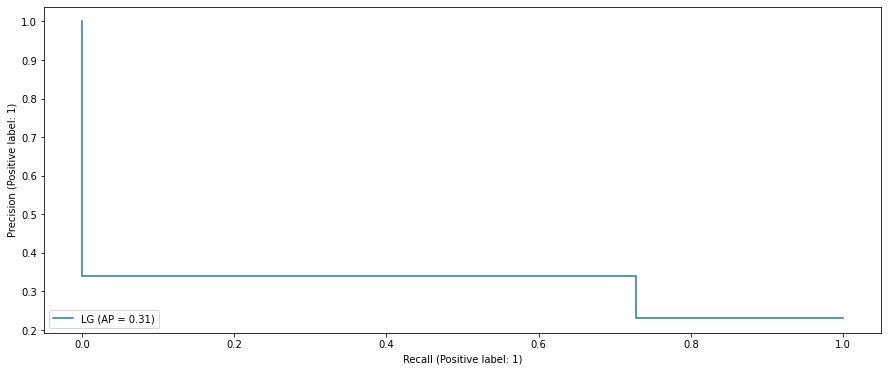

In [139]:
# Precision-Recall curve
y_pred_lgt = logis_model.predict(x_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred_lgt, name="LG")

Conclusion: Overall, Logistic Regeression has less options to tune hyperparameter and the accuracy is also lower than XGBoost. 

# CONCLUSION

* The final XGBoost we choose has a recall score of 74%, and the overall accuracy of 60%. 

* XGBoost is suitable for the probelm stated in this project because:
    * With the same dataset, XGBoost's overall accuracy score and recall score
    * XGBoost provides more options to tune the hyperparameters than Logistic to handle the problem of overfitting and imbalanced data easier.
    * If there is the missing values in the data, Logistic Regression cannot run, while XGBoost can do it, which required less time to prepare the data set for training and testing. In the step of data preparation we still remove all the null value just because we want to compare results of XGBoost and Logistic Regression on the same dataset. 

# Futher suggestions

In briefly, the XGBoost model we found has an acceptable capacity in the prediction of the loan status:

* Due to the indirect access, data description is not fully found so there is still room for improvement in EDA.

* Limit of memory leads to the limit of tuning the model (larger data sample increases significant time to train). Imported more data to train the model will increase its performance (especially it is the case of the ensemble algorithm)

* There will be a part of writing a dashboard using Dash plotly. Please check my github: https://github.com/minhtrang4078/Personal-Loan-Status-Prediction-App